In [ ]:
import os
import time
import json
import math
import random
import hashlib
from pathlib import Path
from typing import List, Dict, Tuple, Set

import requests
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


implementing this determinism via random seed will ensure that any future adjustments we make to our model will be fully reflected in the results of re-running. not any randomness in the e.g. tensor initialisation, data augmentation etc.

In [ ]:
import os, random, numpy as np, torch

SEED = 42

def set_seed(seed=SEED, deterministic=False):
  os.environ["PYTHONHASHSEED"] = str(seed)
  random.seed(seed) # seed on random
  np.random.seed(seed) # seed on numpy random
  torch.manual_seed(seed) # seed on cpu random
  torch.cuda.manual_seed_all(seed) # seed on cuda random
  # cuDNN controls
  torch.backends.cudnn.benchmark = False # maximises seed random in cuda
  torch.backends.cudnn.deterministic = True # *
  if deterministic:
    # optional - stronger determinism; can slow things down
    torch.use_deterministic_algorithms(True)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

set_seed(SEED)

data retrieval

In [ ]:
BASE_DIR = Path("/content/drive/MyDrive/big_cats_project")
OUTPUT_ROOT = BASE_DIR / "data" / "big_cats_raw" # raw downloads go here
SPECIES = {
    "jaguar": "Panthera onca",
    "cheetah": "Acinonyx jubatus",
    "leopard": "Panthera pardus",
}
IMAGES_PER_CLASS = 1500
PER_PAGE = 200 # max observations (assuming one image per observation)
SLEEP_BETWEEN_CALLS = 0.3
ONLY_RESEARCH_GRADE = True

DO_SPLIT = True
SPLIT_ROOT = BASE_DIR / "data" / "big_cats"
SPLITS = (0.70, 0.15, 0.15)

# permanently create directories within google drive folder
for p in [OUTPUT_ROOT, SPLIT_ROOT]:
  p.mkdir(parents=True, exist_ok=True)

SESSION = requests.Session() # creates session
SESSION.headers.update({
    "User-Agent": "iNatDownloader/1.0 (educational use)"
}) # extra info on request

copying drive data into local for faster processing

In [ ]:
DRIVE_ROOT = Path("/content/drive/MyDrive/big_cats_project/data/big_cats")

LOCAL_ROOT = Path("/content/big_cats_local")

import subprocess, time
LOCAL_ROOT.mkdir(parents=True, exist_ok=True)
t0 = time.time()

subprocess.run(["rsync", "-ah", "--delete", f"{DRIVE_ROOT}/", f"{LOCAL_ROOT}/"], check=True)
print(f"Mirrored {DRIVE_ROOT} -> {LOCAL_ROOT} in {time.time()-t0:.1f}s")

Mirrored /content/drive/MyDrive/big_cats_project/data/big_cats -> /content/big_cats_local in 1502.7s


In [ ]:
# directory creation
def safe_mkdir(p: Path):
  p.mkdir(parents=True, exist_ok=True)

# retrieve species' taxon_id to then make observation requests
def get_taxon_id(scientific_name: str) -> int:
  """
  queries iNaturalist/v1/taxa to find the species' taxon_id
  for future observation requests
  """
  url = "https://api.inaturalist.org/v1/taxa"
  params = {
      "q": scientific_name,
      "rank": "species",
      "per_page": 1,
  } # looking for info on scientific_name for which will be in our response
  r = SESSION.get(url, params=params, timeout=30)
  r.raise_for_status()
  data = r.json()
  if not data.get("results"):
    raise ValueError(f"No taxon found for: {scientific_name}")
  return data["results"][0]["id"]

# extract all photos retrieved from the observation api request
def extract_photo_urls_from_observation(obs: dict) -> List[Tuple[str, str]]:
  """
  returns list of (url, license_code)
  """
  urls = []
  photos = obs.get("photos", []) # retrieve list of dictionaries under "photos" in obs
  for p in photos:

    url = p.get("original_url")
    if not url:
      url = p.get("url") or p.get("medium_url") or p.get("small_url")
      if url:
        url = (url.replace("square", "original").replace("small", "original").replace("medium", "original").replace("large", "original"))
    # url = p.get("url") or p.get("original_url") or p.get("medium_url") or p.get("small_url")

    # license_code = p.get("license_code")
    # retrieve any url that's available for that image
    if not url:
      continue
    # if url and license_code:
      # url = url.replace("square", "original").replace("small", "original").replace("medium", "original").replace("large", "original")
      # replace the url with "original" for all to give possibility to retrieving highest res image
    url = url.split("?")[0]
    urls.append(url)
  return urls

In [ ]:
# use taxons to retrieve images of corresponding species
def fetch_photo_urls_for_taxon(taxon_id: int, max_images: int) -> List[str]:
  """
  collect images associated with taxon until we reach max_images or exhaust
  """
  url = "https://api.inaturalist.org/v1/observations"
  params = {
      "taxon_id": taxon_id,
      "per_page": PER_PAGE,
      "order": "desc",
      "order_by": "created_at",
      "photos": "true",
  }
  # if still 0 urls, then comment out "photo_licensed"
  if ONLY_RESEARCH_GRADE:
    params["quality_grade"] = "research"

    photo_urls: List[str] = []
    seen_urls: Set[str] = set()
    page = 1

    pbar = tqdm(total=max_images, desc=f"Collecting URLs for taxon {taxon_id}", leave=False)
    try:
      while len(photo_urls) < max_images:
        params["page"] = page # ensure we get new page of observations on every call
        r = SESSION.get(url, params=params, timeout=60)
        r.raise_for_status()
        data = r.json()
        results = data.get("results", [])
        if page == 1 and results:
          print("Sample photo keys:", list(results[0].get("photos", [{}])[0].keys()))
        if not results:
          break

        new_count = 0
        for obs in results: # per image in the page
          for u in extract_photo_urls_from_observation(obs):
            # use function to retrieve url and license_code
            if u not in seen_urls:
              seen_urls.add(u)
              photo_urls.append(u)
              new_count += 1
              if len(photo_urls) >= max_images:
                break
          if len(photo_urls) >= max_images:
            break

        pbar.update(new_count)
        page += 1
        time.sleep(SLEEP_BETWEEN_CALLS) # politeness to prevent server overload

        # prevent pagination
        if "total_results" in data:
          total_results = data["total_results"]
          max_pages = math.ceil(total_results / PER_PAGE)
          if page > max_pages and new_count == 0:
            break
    finally:
      pbar.close()

    return photo_urls[:max_images]

In [ ]:
# create a filename for the image given url
def filename_from_url(url: str) -> str:
  """
  create a stable filename from the URL; url hashed to prevent
  redownloading duplicates
  """
  h = hashlib.sha1(url.encode("utf-8")).hexdigest()
  ext = ".jpg"
  # checking extension and adjusting accordingly
  for e in [".jpg", ".jpeg", ".png", ".gif", ".webp"]:
    if e in url.lower():
      ext = e
      break
  return f"{h}{ext}"

# given a url and filename, it extracts and stores image in file
def download_one(url: str, out_path: Path) -> bool:
  """
  download a single URL to out_path
  """
  try:
    if out_path.exists():
      return True
    with SESSION.get(url, stream=True, timeout=60) as r:
      # response returned in chunks to prevent memory overload
      r.raise_for_status()

      ctype = r.headers.get("Content-Type", "")
      if "text/html" in ctype:
        return False
      # if error page returns, return false

      tmp = out_path.with_suffix(out_path.suffix + ".part")
      with open(tmp, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
          if chunk:
            f.write(chunk)
      tmp.rename(out_path)

    return True
  except Exception:
    return False

# class-categorised lists of image urls to be downloaded and assigned to respective dir
def download_urls_to_folder(urls: List[str], out_dir: Path) -> int:
  # create class directory
  safe_mkdir(out_dir)

  # how many images were successfully stored
  success = 0

  for url in tqdm(urls, desc=f"Downloading to {out_dir.name}", leave=False):
    fname = filename_from_url(url)
    ok = download_one(url, out_dir / fname)
    success += int(ok)

    time.sleep(0.01)
  return success

# splits files into train/val/test and copies them into respective dir
def split_imagefolder(raw_root: Path, split_root: Path, splits=(0.7, 0.15, 0.15)):
  """
  create train/val/test ImageFolder structure by randomly splitting files
  """

  # ensure correct split
  assert abs(sum(splits) - 1.0) < 1e-6

  # create class list given existing directories
  classes = [d.name for d in raw_root.iterdir() if d.is_dir()]

  # create new directory paths with split dirs included
  for subset in ["train", "val", "test"]:
    for c in classes:
      safe_mkdir(split_root / subset / c)

  # randomly shuffle and split image files
  for c in classes:
    files = [p for p in (raw_root / c).iterdir() if p.is_file()]
    random.shuffle(files)
    n = len(files)
    n_train = int(n * splits[0])
    n_val = int(n * splits[1])
    train_files = files[:n_train]
    val_files = files[n_train:n_train + n_val]
    test_files = files[n_train + n_val:]

    # for every file in every class, copy its contents into its new position within split_root
    def copy_files(fs, dst):
      for src in fs:
        dst_path = split_root / dst / c / src.name
        if not dst_path.exists():
          dst_path.write_bytes(src.read_bytes())

    copy_files(train_files, "train")
    copy_files(val_files, "val")
    copy_files(test_files, "test")

  print(f"Split complete at: {split_root.resolve()}")

In [ ]:
# main flow: create class dir -> get taxon_id for class -> gather photo urls -> download -> split
def main():
  safe_mkdir(OUTPUT_ROOT)

  for label, scientific in SPECIES.items():
    print(f"\n=== {label.upper()} :: {scientific} ===")
    # define and create class dir
    class_dir = OUTPUT_ROOT / label
    safe_mkdir(class_dir)

    # find taxon id
    taxon_id = get_taxon_id(scientific)
    print(f"Taxon ID for {scientific}: {taxon_id}")

    # gather photo urls
    urls = fetch_photo_urls_for_taxon(taxon_id, IMAGES_PER_CLASS)
    print(f"Collected {len(urls)} candidate URLs for {label}")

    # download
    n_ok = download_urls_to_folder(urls, class_dir)
    print(f"Downloaded {n_ok} images to {class_dir}")

  if DO_SPLIT:
    print("\nCreating train/val/test split...")
    split_imagefolder(OUTPUT_ROOT, SPLIT_ROOT, SPLITS)
    print("All done!")

if __name__ == "__main__":
  main()

cheetah :: /content/drive/MyDrive/big_cats_project/data/big_cats/val/cheetah/d1bc5c9041950af01a16d11c31f148c0690cca45.jpg


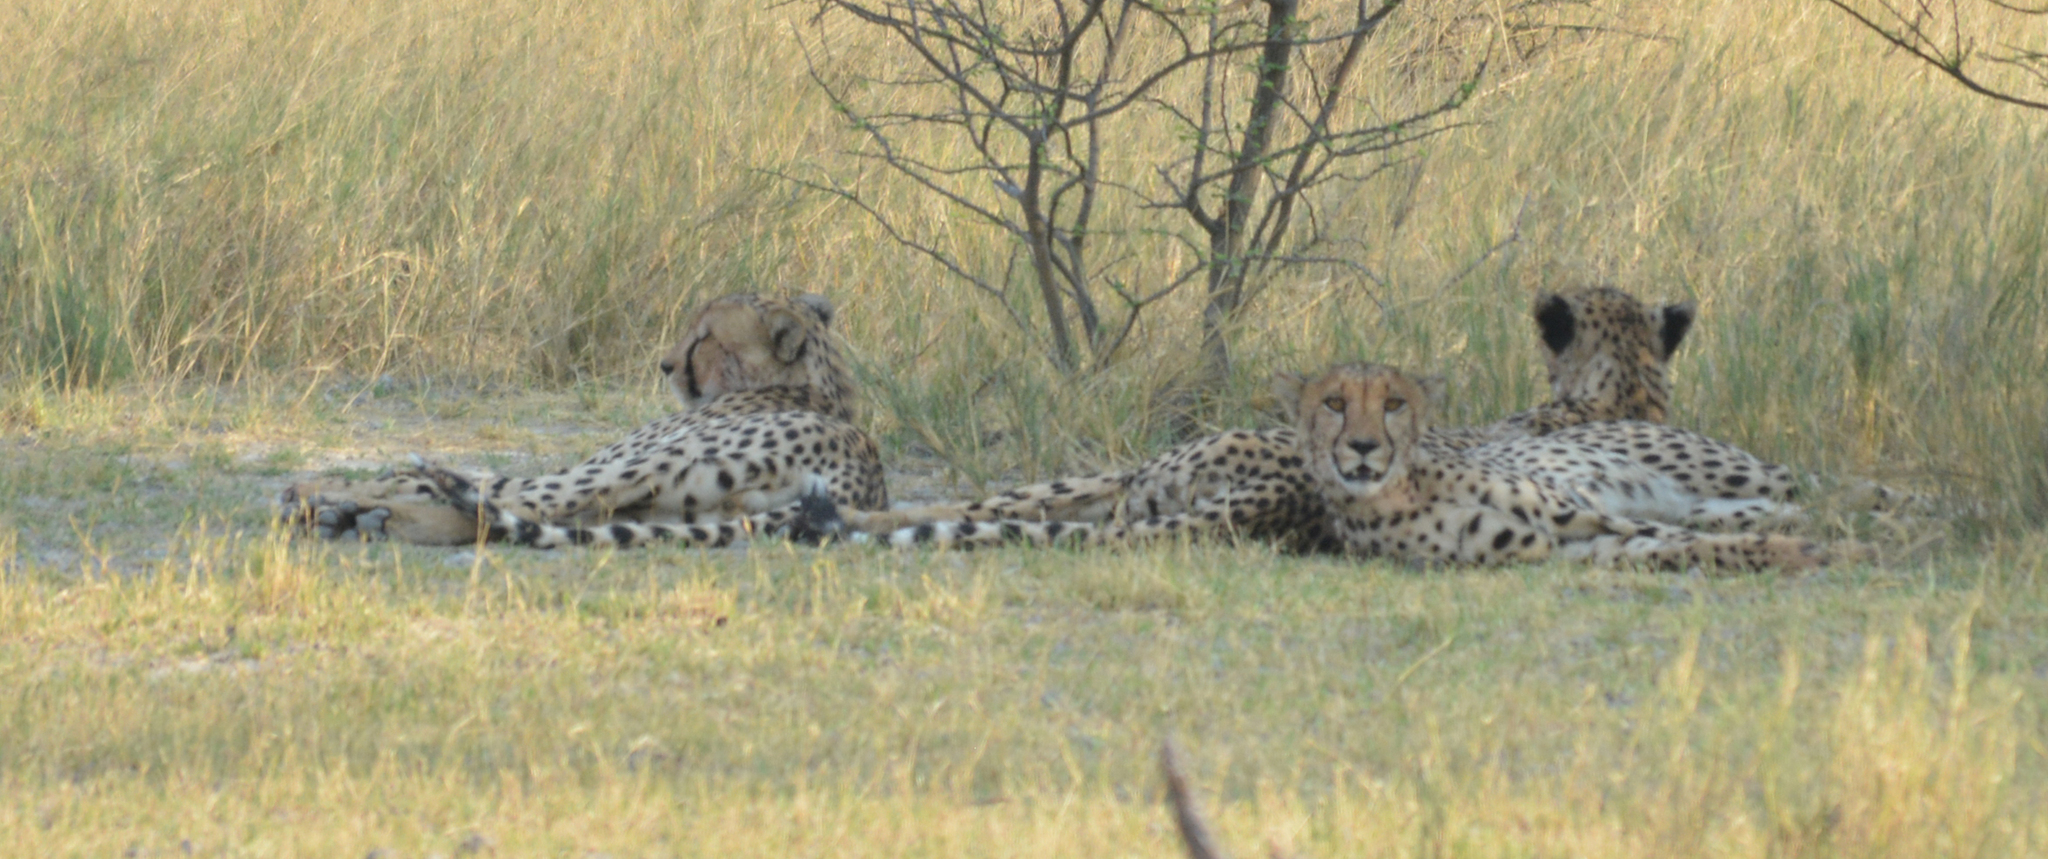

In [ ]:
# visualizing the images
from PIL import Image

image_path = BASE_DIR / "data" / "big_cats"

# all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# random path selection
random_image_path = random.choice(image_path_list)

# get image class name
image_class = random_image_path.parent.stem

# img
img = Image.open(random_image_path)

# image production
print(f"{image_class} :: {random_image_path}")
img

In [ ]:
# data transform and augmentations
from torchvision import datasets, transforms

# imagenet-style normalization
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

# warmup for training data - more tame
train_tfms_warmup = transforms.Compose([
    transforms.RandomResizedCrop(320, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# for training data
train_tfms_main = transforms.Compose([
    transforms.RandomResizedCrop(320, scale=(0.4, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.ColorJitter(0.3, 0.3, 0.3),
    transforms.RandAugment(num_ops=1, magnitude=5), # mag was 6
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    # transforms.RandomErasing(p=0.1, value='random')
])

# for validation data
val_tfms = transforms.Compose([
    # resizing and then centercropping ensures subject is within the final img
    transforms.Resize(352),
    transforms.CenterCrop(320),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

convert all gifs into jpgs

In [ ]:
from pathlib import Path
from PIL import Image

def convert_all_gifs_to_jpg(root: Path):
  for gif in root.rglob("*.gif"):
    try:
      with Image.open(gif) as im:
        im.seek(0) # take first frame
        im = im.convert("RGB") # convert to rgb format
        jpg_path = gif.with_suffix(".jpg")
        im.save(jpg_path, "JPEG", quality=95, optimize=True) # save first frame of gif
      gif.unlink()
    except Exception as e:
      print("failed:", gif, e)

convert_all_gifs_to_jpg(SPLIT_ROOT)

In [ ]:
# transforms dataset and stores in variable
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np

# train - changes based on epoch
train_ds = datasets.ImageFolder(str(LOCAL_ROOT/"train"), transform=train_tfms_main)
# validation
val_ds = datasets.ImageFolder(str(LOCAL_ROOT/"val"), transform=val_tfms)
# test
test_ds = datasets.ImageFolder(str(LOCAL_ROOT/"test"),  transform=val_tfms)
# recalibration
train_ds_noaug = datasets.ImageFolder(str(LOCAL_ROOT/"train"), transform=val_tfms)

# consistent per-worker augmentations
def seed_worker(worker_id):
  worker_seed = SEED + worker_id
  np.random.seed(worker_seed)
  random.seed(worker_seed)

# consistent ordering of samples
g = torch.Generator()
g.manual_seed(SEED)

# despite equal quantity, the model seems to struggle to recognise jaguars. this promotes equal appearance across all 3 classes
counts = np.bincount([t for _,t in train_ds.samples])
w = 1.0 / counts
sample_w = [w[t] for _,t in train_ds.samples]
sampler = WeightedRandomSampler(sample_w, num_samples=len(sample_w), replacement=True)

# python iterables (batches)
train_loader = DataLoader(train_ds,
                          batch_size=32,
                          sampler=sampler,
                          num_workers=2,
                          pin_memory=True,
                          worker_init_fn=seed_worker,
                          generator=g)

val_loader = DataLoader(val_ds,
                        batch_size=32,
                        shuffle=False,
                        num_workers=2,
                        pin_memory=True,
                        worker_init_fn=seed_worker,
                        generator=g)

test_loader = DataLoader(test_ds,
                         batch_size=32,
                         shuffle=False,
                         num_workers=2,
                         pin_memory=True,
                         worker_init_fn=seed_worker,
                         generator=g)

recal_loader = DataLoader(train_ds_noaug,
                          batch_size=64,
                          shuffle=False,
                          num_workers=2,
                          pin_memory=True)

num_classes = len(train_ds.classes)

In [ ]:
train_ds.class_to_idx

{'cheetah': 0, 'jaguar': 1, 'leopard': 2}

In [ ]:
import torch

In [ ]:
# device agnostic code - DO NOT RUN YET
device = "cuda" if torch.cuda.is_available() else "cpu"

### defining mixup and cutmix functions

- lambda in both functions determine the intensity of the mixup/cutmix

In [ ]:
# defining mixup and cutmix fns - encourage finer distinguishing between classes
import torch.nn.functional as F
import random

# mixup - mix of two images via linear interpolation
def mixup_data(x, y, alpha=0.2):
  if alpha <= 0:
    return x, y, y, 1.0

  # via vectorization...

  # creates lambda value which determines proportion within image pairs
  lam = torch.distributions.Beta(alpha, alpha).sample().item()

  # permutation to create pairings
  index = torch.randperm(x.size(0), device=x.device)

  # mixing of pairs
  mixed_x = lam * x + (1 - lam) * x[index]

  # labels of pairings
  y_a, y_b = y, y[index]

  return mixed_x, y_a, y_b, lam

# cutmix - mixing sections of image pairs
def cutmix_data(x, y, alpha=1.0):
  if alpha <= 0:
    return x, y, y, 1.0

  # lambda value for size of cut and paste
  lam = torch.distributions.Beta(alpha, alpha).sample().item()

  # grab dimensions
  B, C, H, W = x.size()

  # permutation to create pairings
  index = torch.randperm(B, device=x.device)

  # cut size
  cut_w = int(W * (1 - lam) ** 0.5)
  cut_h = int(H * (1 - lam) ** 0.5)
  # cut position
  cx = random.randint(0, W - 1)
  cy = random.randint(0, H - 1)
  x1 = max(cx - cut_w // 2, 0); x2 = min(cx + cut_w // 2, W)
  y1 = max(cy - cut_h // 2, 0); y2 = min(cy + cut_h // 2, H)

  # replace specific section with paired image section just created
  x[:, :, y1:y2, x1:x2] = x[index, :, y1:y2, x1:x2]

  lam = 1 -((x2 - x1) * (y2 - y1) / (H * W))

  y_a, y_b = y, y[index]
  return x, y_a, y_b, lam

# computed loss of mixed images
def mix_criterion(criterion, pred, y_a, y_b, lam):
  return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

### building resnet-18 model

- as resnet-18 initially built for 1000 classes, we have adjusted the fc layer for 3 classes
- because of this adjustment, we need to initialize the new weights under kaiming normal distribution so it is compatible

In [ ]:
# building the resnet-18 model
import torch
from torch import nn
import torchvision.models as models

num_classes = 3

model = models.resnet18(weights=None)

# update fc layer to have output 3 rather than default (1000)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

# kaiming initialization on updated fc weights due to relu-influenced layers
nn.init.kaiming_normal_(model.fc.weight, mode="fan_out", nonlinearity="relu")
# initialize to 0 otherwise arbitrary influence on parameters
if model.fc.bias is not None:
  nn.init.zeros_(model.fc.bias)

### loss, optimizer, and scheduler

- loss is crossentropy, but also due to mixup/cutmix augmentation we will also use our own custom criterion
- optimizer will be sgd
- we implement a warmup scheduler and cosine scheduler to prevent unstable gradient changing and convergence respectively

In [ ]:
# loss, optimizer and scheduler
import torch.optim as optim
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR

# increasing weight of cheetah so false negatives hurt more
class_weights = torch.tensor([1.30, 1.10, 1.25], device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.SGD(
    model.parameters(),
    lr=0.01, # updated from 0.1 for 4th | changed again
    momentum=0.9, # improves efficiency during step by minimising oscillations
    weight_decay=1e-4 # overfitting technique by preventing too large weights
)

# warmup scheduler - prevent unstable gradient updates
warmup = LinearLR(
    optimizer,
    start_factor=0.01,
    end_factor=1.0,
    total_iters=5
)

epochs = 50

# cosine annealing
cosine = CosineAnnealingLR(optimizer,
                           T_max=epochs-5,
                           eta_min=1e-5)

# chain them together
scheduler = SequentialLR(
    optimizer,
    schedulers=[warmup, cosine],
    milestones=[5]
)

# tracking learning rate to ensure scheduler behaves as expected
def current_lr(opt):
  return opt.param_groups[0]['lr']

In [ ]:
class ModelEMA:
  """Exponential Moving Average of model weights (params + BN buffers)."""
  def __init__(self, model, decay=0.999):
    self.decay = decay
    self.device = next(model.parameters()).device
    # weights and biases for each layer as tensors
    self.shadow = {
        k: v.detach().clone()
        for k, v in model.state_dict().items()
        if torch.is_floating_point(v)
    }

  # applies current weights to EMA dictionary
  @torch.no_grad()
  def update(self, model):
    """Call after each optimizer step."""
    msd = model.state_dict()
    for k, v in self.shadow.items():
      v.mul_(self.decay).add_(msd[k].detach(), alpha=1.0 - self.decay)

  @torch.no_grad()
  def apply_to(self, model):
    """Load EMA weights into the live model (in-place)."""
    msd = model.state_dict()
    for k, v in self.shadow.items():
      msd[k].copy_(v)

  def state_dict(self):
    return {k: v.cpu() for k, v in self.shadow.items()}

  def load_state_dict(self, d, device):
    self.shadow = {k: v.to(device) for k, v in d.items()}

In [ ]:
ema = ModelEMA(model, decay=0.999)

### helper functions epoch_phase(), evaluate(), and train_one_epoch()

- epoch_phase() determines the mix probability depending on epoch

- evaluate() determines performance of model once trained

- train_one_epoch() is training loop for one epoch

In [ ]:
# building training and evaluation loop
import torch
from torch import amp
from torch.cuda.amp import GradScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import numpy as np
from pathlib import Path
import time

model.to(device)

EPOCHS = 50
WARMUP_EPOCHS = 5 # updated from 5 for 4th | changed to 5
COOLDOWN_EPOCHS = 8 # updated from 5 for 4th | changed to 8
MIXUP_ALPHA = 0.2 # strength of mixup
CUTMIX_ALPHA = 0.5 # updated from 1 for 4th
P_MIXED = 0.25 # updated from 0.7 for 4th | updated again to 0.4 | again to 0.3

CLIP_NORM = 1.0 # g. clipping - max magnitude of gradients to prevent oscillation

MIN_EPOCH_BEFORE_STOP = 12

# save model parameters with best macro-F1 scores
CKPT_DIR = BASE_DIR / "checkpoints"
CKPT_DIR.mkdir(parents=True, exist_ok=True)
BEST_CKPT = CKPT_DIR / "best_val_f1.pt"
BEST_CKPT_2 = CKPT_DIR / "best_val_f1_2.pt"

# rescales float16 value gradients so they're usable and not too small
scaler = GradScaler()

# determing mix based on epoch
def epoch_phase(epoch):
  """Return mixing policy for this epoch"""
  if epoch < WARMUP_EPOCHS:
    return "no-mix"
  if epoch >= EPOCHS - COOLDOWN_EPOCHS:
    return "cooldown"
  return "main"

# evaluation of model performance
@torch.no_grad()
def evaluate(model, loader, criterion):
  model.eval()
  total_loss = 0.0
  all_preds, all_labels = [], []

  for images, labels in loader:
    images, labels = images.to(device), labels.to(device)
    with amp.autocast('cuda', enabled=torch.cuda.is_available()):
      # forward pass
      logits = model(images)
      # loss
      loss = criterion(logits, labels)
    total_loss += loss.item() * images.size(0)
    # pred labels
    preds = torch.argmax(logits, dim=1)
    # add to list
    all_preds.append(preds.cpu())
    all_labels.append(labels.cpu())
  # convert to np and calculate avg
  all_preds = torch.cat(all_preds).numpy()
  all_labels = torch.cat(all_labels).numpy()
  avg_loss = total_loss / len(loader.dataset)
  # macrof1 and confusion matrix
  macro_f1 = f1_score(all_labels, all_preds, average="macro")
  cm = confusion_matrix(all_labels, all_preds)

  return avg_loss, macro_f1, cm, all_labels, all_preds

# evaluation but include bias for cheetah to improve recall (borderline cases)
CHEETAH_IDX = train_loader.dataset.class_to_idx["cheetah"]
NUM_CLASSES = len(train_loader.dataset.classes)

@torch.no_grad()
def evaluate_with_bias(model, loader, criterion, cheetah_bias=0.0):
  model.eval()
  total_loss = 0.0
  all_preds, all_labels = [], []

  # bias vector added to logits before argmax
  bias_vec = torch.zeros(NUM_CLASSES, device=device)
  bias_vec[CHEETAH_IDX] = cheetah_bias

  for images, labels in loader:
    images, labels = images.to(device), labels.to(device)
    with amp.autocast('cuda', enabled=torch.cuda.is_available()):
      logits = model(images)
      logits = logits + bias_vec
      loss = criterion(logits, labels)

    total_loss += loss.item() * images.size(0)
    preds = torch.argmax(logits, dim=1)
    all_preds.append(preds.cpu())
    all_labels.append(labels.cpu())

  all_preds = torch.cat(all_preds).numpy()
  all_labels = torch.cat(all_labels).numpy()
  avg_loss = total_loss / len(loader.dataset)
  macro_f1 = f1_score(all_labels, all_preds, average="macro")
  cm = confusion_matrix(all_labels, all_preds)

  return avg_loss, macro_f1, cm, all_labels, all_preds

# train model for one epoch
def train_one_epoch(model, loader, optimizer, criterion, epoch):
  model.train()
  total_loss = 0.0
  n = 0
  phase = epoch_phase(epoch) # determines if mixing based on schedule

  # mixing policy
  if phase == "no-mix":
    p_mixed = 0.0
  elif phase == "cooldown":
    p_mixed = 0.0 # was previously 0.2 before 4th training loop
  else:
    p_mixed = P_MIXED

  for images, labels in loader:
    images, labels = images.to(device), labels.to(device)

    # batch mixing determination & execution
    use_mixing = (np.random.rand() < p_mixed)
    if use_mixing:
      # 50-50 between mixup and cutmix once mixing has been decided
      # if np.random.rand() < 0.5:
      images, y_a, y_b, lam = mixup_data(images, labels, alpha=MIXUP_ALPHA)
      # else:
        # images, y_a, y_b, lam = cutmix_data(images, labels, alpha=CUTMIX_ALPHA)

    # zero grad with memory release
    optimizer.zero_grad(set_to_none=True)
    # forward prop and loss
    with amp.autocast('cuda', enabled=torch.cuda.is_available()):
      logits = model(images)
      # loss based on whether mixed (as two labels)
      if use_mixing:
        loss = mix_criterion(criterion, logits, y_a, y_b, lam)
      else:
        loss = criterion(logits, labels)

    # gradients are scaled up before backprop
    scaler.scale(loss).backward()
    if CLIP_NORM is not None:
      # must scale true gradients
      scaler.unscale_(optimizer)
      # gradient clipping occurring
      torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
    # gradient descent safely under AMP
    scaler.step(optimizer)
    scaler.update()
    ema.update(model)

    # calculates total loss for all images in batch
    total_loss += loss.item() * images.size(0)
    # adds to tally of total images across all batches
    n += images.size(0)

  # average loss for each image
  return total_loss / n

/tmp/ipython-input-1969280426.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


### training loop

In [ ]:
# training loop
best_f1 = -1.0
patience = 7 # epochs where macro_F1 score doesn't improve before early stopping
since_improved = 0

for epoch in range(EPOCHS):
  t0 = time.time()

  train_loss = train_one_epoch(model, train_loader, optimizer, criterion, epoch)

  # ticks scheduler forward in prep for changing schedules
  if scheduler is not None:
    scheduler.step()

  # validation set testing
  val_loss, val_f1, cm, y_true, y_pred = evaluate(model, val_loader, criterion)

  took = time.time() - t0

  # results of validation set
  print(f"[{epoch+1:03d}/{EPOCHS}] {epoch_phase(epoch):>7s} "
  f"| train_loss {train_loss:.4f}) "
  f"| val_loss {val_loss:.4f} "
  f"| val_macroF1 {val_f1:.4f} "
  f"| {took:.1f}s")

  # parameters with best macro_F1 are saved
  if val_f1 > best_f1:
    best_f1 = val_f1
    since_improved = 0
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best-f1": best_f1,
    }, BEST_CKPT)
    print(f"↳ saved new best (macro-F1={best_f1:.4f}) to {BEST_CKPT}")
  else:
    since_improved += 1
    # implement early stopping if parameters haven't improved for 7+ epochs
    if since_improved >= patience:
      print(f"Early stopping: no F1 improvement for {patience} epochs.")
      break

# load best performing parameters into model ofr final test/eval
if BEST_CKPT.exists():
  state = torch.load(BEST_CKPT, map_location=device)
  model.load_state_dict(state["model_state"])
  print(f"Loaded best checkpoint from epoch {state['epoch']} (F1={state['best-f1']:.4f})")

# detailed report of validation set
try:
  from sklearn.metrics import classification_report
  print(classification_report(y_true, y_pred, target_names=train_loader.dataset.classes))
except Exception:
  pass

/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[001/50]  no-mix | train_loss 7.1944) | val_loss 2.4335 | val_macroF1 0.3706 | 1764.4s
↳ saved new best (macro-F1=0.3706) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1.pt


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[002/50]  no-mix | train_loss 3.1076) | val_loss 2.5715 | val_macroF1 0.3925 | 166.8s
↳ saved new best (macro-F1=0.3925) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1.pt


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[003/50]  no-mix | train_loss 3.2512) | val_loss 3.1573 | val_macroF1 0.3619 | 167.4s


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[004/50]  no-mix | train_loss 3.4238) | val_loss 2.7618 | val_macroF1 0.3858 | 165.7s


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[005/50]  no-mix | train_loss 3.1732) | val_loss 6.3585 | val_macroF1 0.1217 | 165.3s


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[006/50]    main | train_loss 2.5034) | val_loss 2.5417 | val_macroF1 0.2576 | 165.5s


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[007/50]    main | train_loss 2.1568) | val_loss 6.9090 | val_macroF1 0.2044 | 165.3s


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[008/50]    main | train_loss 2.2746) | val_loss 5.8848 | val_macroF1 0.2044 | 163.1s


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[009/50]    main | train_loss 1.7332) | val_loss 2.5760 | val_macroF1 0.3252 | 164.4s
Early stopping: no F1 improvement for 7 epochs.


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[010/50]    main | train_loss 1.8977) | val_loss 1.3179 | val_macroF1 0.3327 | 163.0s
Early stopping: no F1 improvement for 7 epochs.


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[011/50]    main | train_loss 2.0029) | val_loss 0.9547 | val_macroF1 0.5790 | 162.3s
↳ saved new best (macro-F1=0.5790) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1.pt


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[012/50]    main | train_loss 2.0558) | val_loss 2.7605 | val_macroF1 0.2026 | 164.0s


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[013/50]    main | train_loss 1.8629) | val_loss 1.2925 | val_macroF1 0.3281 | 162.0s


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[014/50]    main | train_loss 1.7934) | val_loss 2.8415 | val_macroF1 0.1938 | 162.2s


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[015/50]    main | train_loss 1.6133) | val_loss 2.0536 | val_macroF1 0.3102 | 163.1s


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[016/50]    main | train_loss 1.4209) | val_loss 1.1251 | val_macroF1 0.4410 | 161.7s


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[017/50]    main | train_loss 1.3499) | val_loss 1.0791 | val_macroF1 0.4841 | 161.4s


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[018/50]    main | train_loss 1.5648) | val_loss 0.9497 | val_macroF1 0.4265 | 161.9s
Early stopping: no F1 improvement for 7 epochs.


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[019/50]    main | train_loss 1.3991) | val_loss 1.0842 | val_macroF1 0.4617 | 162.0s
Early stopping: no F1 improvement for 7 epochs.


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[020/50]    main | train_loss 1.4775) | val_loss 0.8673 | val_macroF1 0.5310 | 162.2s
Early stopping: no F1 improvement for 7 epochs.


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[021/50]    main | train_loss 1.4379) | val_loss 0.8821 | val_macroF1 0.5670 | 161.2s
Early stopping: no F1 improvement for 7 epochs.


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[022/50]    main | train_loss 1.2404) | val_loss 0.8736 | val_macroF1 0.4673 | 159.5s
Early stopping: no F1 improvement for 7 epochs.


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[023/50]    main | train_loss 1.2385) | val_loss 0.8586 | val_macroF1 0.5852 | 161.7s
↳ saved new best (macro-F1=0.5852) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1.pt


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[024/50]    main | train_loss 1.2154) | val_loss 0.8367 | val_macroF1 0.6023 | 162.5s
↳ saved new best (macro-F1=0.6023) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1.pt


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[025/50]    main | train_loss 1.2327) | val_loss 0.7811 | val_macroF1 0.5955 | 164.3s


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[026/50]    main | train_loss 1.1254) | val_loss 0.9121 | val_macroF1 0.5075 | 161.6s


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[027/50]    main | train_loss 1.1508) | val_loss 1.1852 | val_macroF1 0.4241 | 161.6s


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[028/50]    main | train_loss 1.1631) | val_loss 1.3342 | val_macroF1 0.3951 | 165.5s


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[029/50]    main | train_loss 1.1678) | val_loss 0.9984 | val_macroF1 0.3418 | 164.1s


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[030/50]    main | train_loss 1.2045) | val_loss 1.3789 | val_macroF1 0.3208 | 165.1s


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[031/50]    main | train_loss 1.0784) | val_loss 0.8729 | val_macroF1 0.5448 | 165.2s
Early stopping: no F1 improvement for 7 epochs.


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-889371918.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[032/50]    main | train_loss 1.0479) | val_loss 0.8960 | val_macroF1 0.5810 | 166.5s
Early stopping: no F1 improvement for 7 epochs.


/tmp/ipython-input-889371918.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


KeyboardInterrupt: 

In [ ]:
if BEST_CKPT.exists():
  state = torch.load(BEST_CKPT, map_location=device)
  model.load_state_dict(state["model_state"])
  print(f"Loaded best checkpoint from epoch {state['epoch']} (F1={state['best-f1']:.4f})")

NameError: name 'BEST_CKPT' is not defined

In [ ]:
try:
  from sklearn.metrics import classification_report
  print(classification_report(y_true, y_pred, target_names=train_loader.dataset.classes))
except Exception:
  pass

              precision    recall  f1-score   support

     cheetah       0.77      0.66      0.71       225
      jaguar       0.31      0.85      0.46        59
     leopard       0.70      0.49      0.57       225

    accuracy                           0.61       509
   macro avg       0.59      0.66      0.58       509
weighted avg       0.68      0.61      0.62       509



we're unsure whether the storage problem with google drive during download led to way less jaguar data being downloaded

In [ ]:
from pathlib import Path

root = Path("/content/drive/MyDrive/big_cats_project/data/big_cats")

for split in ["train", "val", "test"]:
  for cls in ["cheetah", "jaguar", "leopard"]:
    n = len(list((root/split/cls).glob("*")))
    print(f"{split}/{cls}: {n}")

train/cheetah: 1050
train/jaguar: 1050
train/leopard: 1050
val/cheetah: 225
val/jaguar: 225
val/leopard: 225
test/cheetah: 225
test/jaguar: 225
test/leopard: 225


In [ ]:
from pathlib import Path

root = Path("/content/drive/MyDrive/big_cats_project/data/big_cats_raw")

for cls in ["cheetah", "jaguar", "leopard"]:
  n = len(list((root/cls).glob("*")))
  print(f"{cls}: {n}")

cheetah: 1500
jaguar: 1500
leopard: 1500


recreating train/val/test split for jaguar and then using it as a replacement for old split

In [ ]:
import random, shutil
from pathlib import Path

# paths
RAW_ROOT = Path("/content/drive/MyDrive/big_cats_project/data/big_cats_raw")
CLASS_NAME = "jaguar"

# split ratios
splits = (0.70, 0.15, 0.15)

# get all jaguar files
files = [p for p in (RAW_ROOT / CLASS_NAME).iterdir() if p.is_file()]
random.shuffle(files)

# compute split sizes
n = len(files)
n_train = int(n * splits[0])
n_val = int(n * splits[1])
train_files = files[:n_train]
val_files = files[n_train:n_train+n_val]
test_files = files[n_train+n_val:]

print(f"jaguar total:{n} -> train={len(train_files)}, val={len(val_files)}, test={len(test_files)}")

# clear old split folders for jaguar
for subset in ["train", "val", "test"]:
  subset_dir = SPLIT_ROOT / subset / CLASS_NAME
  if subset_dir.exists():
    shutil.rmtree(subset_dir)
  subset_dir.mkdir(parents=True, exist_ok=True)

# copy new files into place
def copy_files_j(file_list, dst):
  for src in file_list:
    dst_path = dst / src.name
    shutil.copy2(src, dst_path)

copy_files_j(train_files, SPLIT_ROOT / "train" / CLASS_NAME)
copy_files_j(val_files, SPLIT_ROOT / "val" / CLASS_NAME)
copy_files_j(test_files, SPLIT_ROOT / "test" / CLASS_NAME)

print("jaguar resplit complete")

jaguar total:1500 -> train=1050, val=225, test=225
jaguar resplit complete


### training loop 2

running another training loop following the update to the jaguar dataset for which now its train/val/test split is equal to the other two classes.

what we expect following this:
- greater precision given the increased jaguar data in val set
- lower recall given the increased jaguar data in val set
- potentially improvement for all metrics for all classes as jaguar dataset will no longer be a bottleneck and therefore more epoch training

In [ ]:
# training loop
best_f1 = -1.0
patience = 7 # epochs where macro_F1 score doesn't improve before early stopping
since_improved = 0

for epoch in range(EPOCHS):
  t0 = time.time()

  train_loss = train_one_epoch(model, train_loader, optimizer, criterion, epoch)

  # ticks scheduler forward in prep for changing schedules
  if scheduler is not None:
    scheduler.step()

  # validation set testing
  val_loss, val_f1, cm, y_true, y_pred = evaluate(model, val_loader, criterion)

  took = time.time() - t0

  # results of validation set
  print(f"[{epoch+1:03d}/{EPOCHS}] {epoch_phase(epoch):>7s} "
  f"| train_loss {train_loss:.4f}) "
  f"| val_loss {val_loss:.4f} "
  f"| val_macroF1 {val_f1:.4f} "
  f"| {took:.1f}s")

  # parameters with best macro_F1 are saved
  if val_f1 > best_f1:
    best_f1 = val_f1
    since_improved = 0
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best-f1": best_f1,
    }, BEST_CKPT)
    print(f"↳ saved new best (macro-F1={best_f1:.4f}) to {BEST_CKPT_2}")
  else:
    since_improved += 1
    # implement early stopping if parameters haven't improved for 7+ epochs
    if since_improved >= patience:
      print(f"Early stopping: no F1 improvement for {patience} epochs.")
      break

# load best performing parameters into model ofr final test/eval
if BEST_CKPT_2.exists():
  state = torch.load(BEST_CKPT_2, map_location=device)
  model.load_state_dict(state["model_state"])
  print(f"Loaded best checkpoint from epoch {state['epoch']} (F1={state['best-f1']:.4f})")

# detailed report of validation set
try:
  from sklearn.metrics import classification_report
  print(classification_report(y_true, y_pred, target_names=train_loader.dataset.classes))
except Exception:
  pass

/tmp/ipython-input-1888456011.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1888456011.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[001/50]  no-mix | train_loss 8.0762) | val_loss 6.8111 | val_macroF1 0.3442 | 737.6s
↳ saved new best (macro-F1=0.3442) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1_2.pt


/tmp/ipython-input-1888456011.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1888456011.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[002/50]  no-mix | train_loss 3.2048) | val_loss 2.7518 | val_macroF1 0.3627 | 174.5s
↳ saved new best (macro-F1=0.3627) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1_2.pt


/tmp/ipython-input-1888456011.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1888456011.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[003/50]  no-mix | train_loss 3.0866) | val_loss 3.3222 | val_macroF1 0.3484 | 172.0s


/tmp/ipython-input-1888456011.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1888456011.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[004/50]  no-mix | train_loss 3.0414) | val_loss 6.7148 | val_macroF1 0.2799 | 170.6s


/tmp/ipython-input-1888456011.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/tmp/ipython-input-1888456011.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[005/50]  no-mix | train_loss 2.7907) | val_loss 4.3955 | val_macroF1 0.2126 | 167.9s


/tmp/ipython-input-1888456011.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1888456011.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[006/50]    main | train_loss 2.8382) | val_loss 4.2687 | val_macroF1 0.2267 | 168.8s


/tmp/ipython-input-1888456011.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1888456011.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[007/50]    main | train_loss 2.1111) | val_loss 1.4394 | val_macroF1 0.4602 | 168.7s
↳ saved new best (macro-F1=0.4602) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1_2.pt


/tmp/ipython-input-1888456011.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1888456011.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[008/50]    main | train_loss 1.9583) | val_loss 3.1321 | val_macroF1 0.1743 | 170.2s


/tmp/ipython-input-1888456011.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1888456011.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[009/50]    main | train_loss 2.0124) | val_loss 2.3341 | val_macroF1 0.3669 | 166.8s


/tmp/ipython-input-1888456011.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1888456011.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[010/50]    main | train_loss 1.5140) | val_loss 2.4302 | val_macroF1 0.1706 | 165.8s


/tmp/ipython-input-1888456011.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1888456011.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[011/50]    main | train_loss 1.6900) | val_loss 2.4993 | val_macroF1 0.1585 | 168.8s


/tmp/ipython-input-1888456011.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1888456011.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[012/50]    main | train_loss 1.4520) | val_loss 0.9968 | val_macroF1 0.5070 | 168.1s
↳ saved new best (macro-F1=0.5070) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1_2.pt


/tmp/ipython-input-1888456011.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1888456011.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[013/50]    main | train_loss 1.6642) | val_loss 2.7199 | val_macroF1 0.1706 | 169.8s


/tmp/ipython-input-1888456011.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1888456011.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[014/50]    main | train_loss 1.4230) | val_loss 0.9606 | val_macroF1 0.5294 | 167.2s
↳ saved new best (macro-F1=0.5294) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1_2.pt


/tmp/ipython-input-1888456011.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1888456011.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[015/50]    main | train_loss 1.6758) | val_loss 3.1612 | val_macroF1 0.1706 | 169.5s


/tmp/ipython-input-1888456011.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1888456011.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[016/50]    main | train_loss 1.4692) | val_loss 1.3987 | val_macroF1 0.2503 | 167.8s


/tmp/ipython-input-1888456011.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1888456011.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[017/50]    main | train_loss 1.4610) | val_loss 4.0717 | val_macroF1 0.1585 | 164.6s


/tmp/ipython-input-1888456011.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1888456011.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[018/50]    main | train_loss 1.6986) | val_loss 1.9608 | val_macroF1 0.1862 | 165.0s


/tmp/ipython-input-1888456011.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1888456011.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[019/50]    main | train_loss 1.6385) | val_loss 1.1767 | val_macroF1 0.4903 | 164.9s


/tmp/ipython-input-1888456011.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1888456011.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[020/50]    main | train_loss 1.5467) | val_loss 1.6209 | val_macroF1 0.3498 | 165.9s


/tmp/ipython-input-1888456011.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1888456011.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[021/50]    main | train_loss 1.3464) | val_loss 1.4250 | val_macroF1 0.3098 | 165.6s
Early stopping: no F1 improvement for 7 epochs.
              precision    recall  f1-score   support

     cheetah       0.87      0.26      0.40       225
      jaguar       0.00      0.00      0.00       204
     leopard       0.37      0.96      0.53       225

    accuracy                           0.42       654
   macro avg       0.41      0.41      0.31       654
weighted avg       0.42      0.42      0.32       654



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print("TRAIN:", train_ds.class_to_idx)
print("VAL: ", val_ds.class_to_idx)
# print("TEST:", test_ds.class_to_idx)

TRAIN: {'cheetah': 0, 'jaguar': 1, 'leopard': 2}
VAL:  {'cheetah': 0, 'jaguar': 1, 'leopard': 2}


debugging to figure out why jaguar is outputting 0...

####running the training loop for one epoch to determine if y_pred is producing jaguar (index 1) at all

In [ ]:
BEST_CKPT_3 = CKPT_DIR / "best_val_f1_3.pt"

In [ ]:
# training loop
best_f1 = -1.0
patience = 7 # epochs where macro_F1 score doesn't improve before early stopping
since_improved = 0

for epoch in range(1):
  t0 = time.time()

  train_loss = train_one_epoch(model, train_loader, optimizer, criterion, epoch)

  # ticks scheduler forward in prep for changing schedules
  if scheduler is not None:
    scheduler.step()

  # validation set testing
  val_loss, val_f1, cm, y_true, y_pred = evaluate(model, val_loader, criterion)

  took = time.time() - t0

  # results of validation set
  print(f"[{epoch+1:03d}/{EPOCHS}] {epoch_phase(epoch):>7s} "
  f"| train_loss {train_loss:.4f}) "
  f"| val_loss {val_loss:.4f} "
  f"| val_macroF1 {val_f1:.4f} "
  f"| {took:.1f}s")

  # parameters with best macro_F1 are saved
  if val_f1 > best_f1:
    best_f1 = val_f1
    since_improved = 0
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best-f1": best_f1,
    }, BEST_CKPT_3)
    print(f"↳ saved new best (macro-F1={best_f1:.4f}) to {BEST_CKPT_3}")
  else:
    since_improved += 1
    # implement early stopping if parameters haven't improved for 7+ epochs
    if since_improved >= patience:
      print(f"Early stopping: no F1 improvement for {patience} epochs.")
      break

# load best performing parameters into model ofr final test/eval
if BEST_CKPT_3.exists():
  state = torch.load(BEST_CKPT_3, map_location=device)
  model.load_state_dict(state["model_state"])
  print(f"Loaded best checkpoint from epoch {state['epoch']} (F1={state['best-f1']:.4f})")

# detailed report of validation set
try:
  from sklearn.metrics import classification_report
  print(classification_report(y_true, y_pred, target_names=train_loader.dataset.classes))
except Exception:
  pass

/tmp/ipython-input-1888456011.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1888456011.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[001/50]  no-mix | train_loss 8.0762) | val_loss 6.8111 | val_macroF1 0.3442 | 1446.2s
↳ saved new best (macro-F1=0.3442) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1_3.pt
Loaded best checkpoint from epoch 0 (F1=0.3442)
              precision    recall  f1-score   support

     cheetah       0.48      0.57      0.52       225
      jaguar       0.33      0.01      0.03       204
     leopard       0.39      0.64      0.48       225

    accuracy                           0.42       654
   macro avg       0.40      0.41      0.34       654
weighted avg       0.40      0.42      0.35       654



In [ ]:
# is jaguar ever being selected...?
import numpy as np
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(271), np.int64(1): np.int64(9), np.int64(2): np.int64(374)}


we believe the support for jaguar being 204 instead of 225 is that there could be 21 images that aren't jpgs. now checking...

In [ ]:
# run this one again to confirm 224 jpgs
from collections import Counter
from pathlib import Path

val_jag = Path(SPLIT_ROOT/"val"/"jaguar")
print("val/jag total (any ext):", len(list(val_jag.iterdir())))
print("by ext:", Counter(p.suffix.lower() for p in val_jag.iterdir()))
print("ImageFolder sees:", sum(1 for p,_ in val_ds.samples if val_ds.classes[_]=="jaguar"))

val/jag total (any ext): 225
by ext: Counter({'.jpg': 157, '.jpeg': 67, '.png': 1})
ImageFolder sees: 225


In [ ]:
val_leo = Path(SPLIT_ROOT/"val"/"leopard")
print("val/leo total (any ext):", len(list(val_leo.iterdir())))
print("by ext:", Counter(p.suffix.lower() for p in val_leo.iterdir()))
print("ImageFolder sees:", sum(1 for p,_ in val_ds.samples if val_ds.classes[_]=="leopard"))

val/leo total (any ext): 225
by ext: Counter({'.jpg': 197, '.jpeg': 28})
ImageFolder sees: 225


In [ ]:
# load ckpt_3 parameters into new model
ckpt_path = BEST_CKPT_3
assert ckpt_path.exists(), f"missing checkpoint: {ckpt_path}"
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state["model_state"])
model.to(device).eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

re-evaluate with existing model params to see if jaguar is now selected more often due to 225 val

In [ ]:
avg_loss_j, macro_f1_j, cm_j, all_labels_j, all_preds_j = evaluate(model, val_loader, criterion)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


likely due to resetting of model parameters

In [ ]:
import numpy as np
unique, counts = np.unique(all_preds_j, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(274), np.int64(1): np.int64(12), np.int64(2): np.int64(389)}


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(all_labels_j, all_preds_j, target_names=train_ds.classes))

              precision    recall  f1-score   support

     cheetah       0.47      0.57      0.51       225
      jaguar       0.50      0.03      0.05       225
     leopard       0.37      0.64      0.47       225

    accuracy                           0.41       675
   macro avg       0.45      0.41      0.35       675
weighted avg       0.45      0.41      0.35       675



retraining following:
- fixed jaguar support

- LR reduction (more time before making conclusions) 0.1 -> 0.05

- warmup to 10 epochs (help distinguish better between jaguar and leopard) 5 -> 10

- reducing mix strength and frequency
P_MIXED = 0.7 -> 0.5
mixup_alpha = 0.2
cutmix_alpha = 1 -> 0.5

- cooldown to 10 epochs with no mixing 5 -> 10 | 0.2 -> 0

In [ ]:
BEST_CKPT_4 = CKPT_DIR / "best_val_f1_4.pt"

In [ ]:
# training loop
best_f1 = -1.0
patience = 7 # epochs where macro_F1 score doesn't improve before early stopping
since_improved = 0

for epoch in range(EPOCHS):
  t0 = time.time()

  train_loss = train_one_epoch(model, train_loader, optimizer, criterion, epoch)

  # ticks scheduler forward in prep for changing schedules
  if scheduler is not None:
    scheduler.step()

  # validation set testing
  val_loss, val_f1, cm, y_true, y_pred = evaluate(model, val_loader, criterion)

  took = time.time() - t0

  # results of validation set
  print(f"[{epoch+1:03d}/{EPOCHS}] {epoch_phase(epoch):>7s} "
  f"| train_loss {train_loss:.4f}) "
  f"| val_loss {val_loss:.4f} "
  f"| val_macroF1 {val_f1:.4f} "
  f"| {took:.1f}s")

  # parameters with best macro_F1 are saved
  if val_f1 > best_f1:
    best_f1 = val_f1
    since_improved = 0
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best-f1": best_f1,
    }, BEST_CKPT_4)
    print(f"↳ saved new best (macro-F1={best_f1:.4f}) to {BEST_CKPT_4}")
  else:
    since_improved += 1
    # implement early stopping if parameters haven't improved for 7+ epochs
    if since_improved >= patience:
      print(f"Early stopping: no F1 improvement for {patience} epochs.")
      break

# load best performing parameters into model ofr final test/eval
if BEST_CKPT_4.exists():
  state = torch.load(BEST_CKPT_4, map_location=device)
  model.load_state_dict(state["model_state"])
  print(f"Loaded best checkpoint from epoch {state['epoch']} (F1={state['best-f1']:.4f})")

# detailed report of validation set
try:
  from sklearn.metrics import classification_report
  print(classification_report(y_true, y_pred, target_names=train_loader.dataset.classes))
except Exception:
  pass

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[001/50]  no-mix | train_loss 9.4798) | val_loss 6.6776 | val_macroF1 0.3015 | 1000.1s
↳ saved new best (macro-F1=0.3015) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1_4.pt


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[002/50]  no-mix | train_loss 3.2898) | val_loss 1.8215 | val_macroF1 0.4235 | 993.4s
↳ saved new best (macro-F1=0.4235) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1_4.pt


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[003/50]  no-mix | train_loss 2.5852) | val_loss 2.4223 | val_macroF1 0.3283 | 1000.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[004/50]  no-mix | train_loss 2.6745) | val_loss 2.7248 | val_macroF1 0.3625 | 995.2s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[005/50]  no-mix | train_loss 2.6490) | val_loss 3.9343 | val_macroF1 0.2537 | 994.7s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[006/50]  no-mix | train_loss 2.6872) | val_loss 2.7479 | val_macroF1 0.3667 | 1002.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[007/50]  no-mix | train_loss 2.3322) | val_loss 2.4420 | val_macroF1 0.2999 | 1006.5s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[008/50]  no-mix | train_loss 1.8634) | val_loss 1.9318 | val_macroF1 0.2930 | 994.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[009/50]  no-mix | train_loss 1.7129) | val_loss 5.7662 | val_macroF1 0.1667 | 962.6s
Early stopping: no F1 improvement for 7 epochs.
Loaded best checkpoint from epoch 1 (F1=0.4235)
              precision    recall  f1-score   support

     cheetah       0.33      1.00      0.50       225
      jaguar       0.00      0.00      0.00       225
     leopard       0.00      0.00      0.00       225

    accuracy                           0.33       675
   macro avg       0.11      0.33      0.17       675
weighted avg       0.11      0.33      0.17       675



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
ckpt_path = BEST_CKPT_4
assert ckpt_path.exists(), f"checkpoint not found: {ckpt_path}"
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state["model_state"])
model.to(device).eval()
print(f"loaded {ckpt_path.name} (best_f1={state.get('best_f1') or state.get('best-f1'):.4f})")

loaded best_val_f1_4.pt (best_f1=0.4235)


the model is still struggling to find a distinguishable difference between leopard and jaguar, resulting in single-class collpase where it just predicts cheetah every time

therefore, the following changes have been made to allow for the model to identify the subtle differences between jaguar and leopard - such as less image augmentation and more time spent on the raw images themselves

changes:
- lower LR: 0.01 (prevent divergence onto cheetah)
- shorter warmup: 5 (reach useful LR sooner and prevent stalling early selection)
- warmup augments ceased for: RandomA, mix, erasing.
- warmup scale now bigger: (0.6, 0.1)
- main: p-mixed: 0.4, mixup_alpha=0.2, cutmix_alpha=0.5, randA: num_ops=1, magnitude=6
- cooldown: no mixup/cutmix
- no early stopping before epoch 12

In [ ]:
BEST_CKPT_5 = CKPT_DIR / "best_val_f1_5.pt"

In [ ]:
# training loop
best_f1 = -1.0
patience = 7 # epochs where macro_F1 score doesn't improve before early stopping
since_improved = 0

for epoch in range(EPOCHS):
  t0 = time.time()

  phase = epoch_phase(epoch)

  # switch train transforms based on epoch
  if phase == "no-mix":
    train_ds.transform = train_tfms_warmup
  elif phase == "cooldown":
    train_ds.transform = train_tfms_main
  else:
    train_ds.transform = train_tfms_main

  train_loss = train_one_epoch(model, train_loader, optimizer, criterion, epoch)

  # ticks scheduler forward in prep for changing schedules
  if scheduler is not None:
    scheduler.step()

  # validation set testing
  val_loss, val_f1, cm, y_true, y_pred = evaluate(model, val_loader, criterion)

  took = time.time() - t0

  # results of validation set
  print(f"[{epoch+1:03d}/{EPOCHS}] {epoch_phase(epoch):>7s} "
  f"| lr {current_lr(optimizer):.5f}"
  f"| train_loss {train_loss:.4f}) "
  f"| val_loss {val_loss:.4f} "
  f"| val_macroF1 {val_f1:.4f} "
  f"| {took:.1f}s")

  # parameters with best macro_F1 are saved
  if val_f1 > best_f1:
    best_f1 = val_f1
    since_improved = 0
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best-f1": best_f1,
    }, BEST_CKPT_5)
    print(f"↳ saved new best (macro-F1={best_f1:.4f}) to {BEST_CKPT_5}")
  else:
    since_improved += 1
    # implement early stopping if parameters haven't improved for 7+ epochs
    if (epoch + 1) >= MIN_EPOCH_BEFORE_STOP and since_improved >= patience:
      print(f"Early stopping: no F1 improvement for {patience} epochs after epoch {MIN_EPOCH_BEFORE_STOP}.")
      break

# load best performing parameters into model ofr final test/eval
if BEST_CKPT_5.exists():
  state = torch.load(BEST_CKPT_5, map_location=device)
  model.load_state_dict(state["model_state"])
  print(f"Loaded best checkpoint from epoch {state['epoch']} (F1={state['best-f1']:.4f})")

# detailed report of validation set
try:
  from sklearn.metrics import classification_report
  print(classification_report(y_true, y_pred, target_names=train_loader.dataset.classes))
except Exception:
  pass

[001/50]  no-mix | lr 0.00208| train_loss 10.7163) | val_loss 9.3375 | val_macroF1 0.3215 | 160.5s
↳ saved new best (macro-F1=0.3215) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1_5.pt
[002/50]  no-mix | lr 0.00406| train_loss 5.7567) | val_loss 5.2178 | val_macroF1 0.3298 | 158.6s
↳ saved new best (macro-F1=0.3298) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1_5.pt
[003/50]  no-mix | lr 0.00604| train_loss 2.6769) | val_loss 2.4424 | val_macroF1 0.4451 | 158.9s
↳ saved new best (macro-F1=0.4451) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1_5.pt
[004/50]  no-mix | lr 0.00802| train_loss 1.8478) | val_loss 2.8170 | val_macroF1 0.3933 | 154.4s


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[005/50]  no-mix | lr 0.01000| train_loss 1.8202) | val_loss 1.9690 | val_macroF1 0.3855 | 150.4s
[006/50]    main | lr 0.00999| train_loss 1.8603) | val_loss 3.0857 | val_macroF1 0.2715 | 149.6s
[007/50]    main | lr 0.00995| train_loss 1.8881) | val_loss 1.9555 | val_macroF1 0.4236 | 150.3s
[008/50]    main | lr 0.00989| train_loss 1.8570) | val_loss 2.0261 | val_macroF1 0.4125 | 151.7s
[009/50]    main | lr 0.00981| train_loss 1.6552) | val_loss 2.7485 | val_macroF1 0.3756 | 148.9s
[010/50]    main | lr 0.00970| train_loss 1.6263) | val_loss 3.0318 | val_macroF1 0.2789 | 146.4s
[011/50]    main | lr 0.00957| train_loss 1.5464) | val_loss 1.7107 | val_macroF1 0.4711 | 146.4s
↳ saved new best (macro-F1=0.4711) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1_5.pt
[012/50]    main | lr 0.00942| train_loss 1.5058) | val_loss 1.7098 | val_macroF1 0.3958 | 154.6s
[013/50]    main | lr 0.00924| train_loss 1.5397) | val_loss 2.6179 | val_macroF1 0.3098 | 149.5s
[014/50]   

a definite improvement from before; jaguar and leopard are being predicted at a precision that you could argue is on-par (or exceeds) human ability.

however, note that the model is predicting jaguar and leopard far more frequently that cheetah - hence low recall for cheetah and high lower precision/higher recall for jaguar and leopard

improvements - better balance hopefully:
- increase weight for loss for cheetah so false negatives hurt more and true positives are reinforced (will increase recall)
- remove randomErasing and reduce randAugment magnitude to give more focus to the raw texture differences between cheetah and leopard/jag
- reduce P_MIXED to 0.3
- increase input images to 288 pixels to allow greater area to represent the fine details distinguishing between the classes
- disable early stopping (all 50 epochs ran)

for testing:
- implement test-time augmentation for which we find the average loss over the input image and its horizontally flipped counterpart. this minimizes sensitivity to a specific orientation, which isn't reflective of real life data.

In [ ]:
BEST_CKPT_6 = CKPT_DIR / "best_val_f1_6.pt"

In [ ]:
# training loop
best_f1 = -1.0
patience = 7 # epochs where macro_F1 score doesn't improve before early stopping
since_improved = 0

use_early_stopping = False

for epoch in range(EPOCHS):
  t0 = time.time()

  phase = epoch_phase(epoch)

  # switch train transforms based on epoch
  if phase == "no-mix":
    train_ds.transform = train_tfms_warmup
  elif phase == "cooldown":
    train_ds.transform = train_tfms_main
  else:
    train_ds.transform = train_tfms_main

  train_loss = train_one_epoch(model, train_loader, optimizer, criterion, epoch)

  # ticks scheduler forward in prep for changing schedules
  if scheduler is not None:
    scheduler.step()

  # validation set testing
  val_loss, val_f1, cm, y_true, y_pred = evaluate(model, val_loader, criterion)

  took = time.time() - t0

  # results of validation set
  print(f"[{epoch+1:03d}/{EPOCHS}] {epoch_phase(epoch):>7s} "
  f"| lr {current_lr(optimizer):.5f}"
  f"| train_loss {train_loss:.4f}) "
  f"| val_loss {val_loss:.4f} "
  f"| val_macroF1 {val_f1:.4f} "
  f"| {took:.1f}s")

  # parameters with best macro_F1 are saved
  if val_f1 > best_f1:
    best_f1 = val_f1
    since_improved = 0
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best-f1": best_f1,
    }, BEST_CKPT_6)
    print(f"↳ saved new best (macro-F1={best_f1:.4f}) to {BEST_CKPT_6}")
  else:
    since_improved += 1
    # implement early stopping if parameters haven't improved for 7+ epochs
    if use_early_stopping and (epoch + 1) >= MIN_EPOCH_BEFORE_STOP and since_improved >= patience:
      print(f"Early stopping: no F1 improvement for {patience} epochs after epoch {MIN_EPOCH_BEFORE_STOP}.")
      break

# load best performing parameters into model ofr final test/eval
if BEST_CKPT_6.exists():
  state = torch.load(BEST_CKPT_6, map_location=device)
  model.load_state_dict(state["model_state"])
  print(f"Loaded best checkpoint from epoch {state['epoch']} (F1={state['best-f1']:.4f})")

# detailed report of validation set
try:
  from sklearn.metrics import classification_report
  print(classification_report(y_true, y_pred, target_names=train_loader.dataset.classes))
except Exception:
  pass

NameError: name 'EPOCHS' is not defined

circa 26 epochs

In [ ]:
ckpt_path = BEST_CKPT_6
assert ckpt_path.exists(), f"checkpoint not found: {ckpt_path}"
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state["model_state"])
model.to(device).eval()
print(f"loaded {ckpt_path.name} (best_f1={state.get('best_f1') or state.get('best-f1'):.4f})")

loaded best_val_f1_6.pt (best_f1=0.5812)


look for precision, recall, macro-f1

In [ ]:
val_loss_6, val_f1_6, cm_6, y_true_6, y_pred_6 = evaluate(model, val_loader, criterion)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


really promising results, and this is only after circa 26 epochs due to the runtime disconnecting. clearly the simplification of the data augmentation has really allowed the model to identify the features that distinguish between the 3 classes

In [ ]:
try:
  from sklearn.metrics import classification_report
  print(classification_report(y_true_6, y_pred_6, target_names=train_loader.dataset.classes))
except Exception:
  pass

              precision    recall  f1-score   support

     cheetah       0.62      0.64      0.63       225
      jaguar       0.60      0.61      0.60       225
     leopard       0.52      0.50      0.51       225

    accuracy                           0.58       675
   macro avg       0.58      0.58      0.58       675
weighted avg       0.58      0.58      0.58       675



resuming from where we left off...

- except cosine scheduler will have to begin again from the top because we didn't save it.
- which means higher LR for the mid-range epochs and another opportunity to explore features/boundaries that distinguish the classes.

In [ ]:
state = torch.load(BEST_CKPT_6, map_location=device)

model.load_state_dict(state["model_state"])
optimizer.load_state_dict(state["optimizer_state"])

try:
  scheduler.load_state_dict(state["scheduler_state"])
except KeyError:
  pass

start_epoch = state["epoch"] + 1
print(f"Resuming from epoch {start_epoch}, best_f1={state.get('best_f1') or state.get('best-f1'):.4f}")

Resuming from epoch 26, best_f1=0.5819


In [ ]:
# training loop
best_f1 = -1.0
patience = 7 # epochs where macro_F1 score doesn't improve before early stopping
since_improved = 0

use_early_stopping = False

for epoch in range(start_epoch, EPOCHS):
  t0 = time.time()

  phase = epoch_phase(epoch)

  # switch train transforms based on epoch
  if phase == "no-mix":
    train_ds.transform = train_tfms_warmup
  elif phase == "cooldown":
    train_ds.transform = train_tfms_main
  else:
    train_ds.transform = train_tfms_main

  train_loss = train_one_epoch(model, train_loader, optimizer, criterion, epoch)

  # ticks scheduler forward in prep for changing schedules
  if scheduler is not None:
    scheduler.step()

  # validation set testing
  val_loss, val_f1, cm, y_true, y_pred = evaluate(model, val_loader, criterion)

  took = time.time() - t0

  # results of validation set
  print(f"[{epoch+1:03d}/{EPOCHS}] {epoch_phase(epoch):>7s} "
  f"| lr {current_lr(optimizer):.5f}"
  f"| train_loss {train_loss:.4f}) "
  f"| val_loss {val_loss:.4f} "
  f"| val_macroF1 {val_f1:.4f} "
  f"| {took:.1f}s")

  # parameters with best macro_F1 are saved
  if val_f1 > best_f1:
    best_f1 = val_f1
    since_improved = 0
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "best-f1": best_f1,
    }, BEST_CKPT_6)
    print(f"↳ saved new best (macro-F1={best_f1:.4f}) to {BEST_CKPT_6}")
  else:
    since_improved += 1
    # implement early stopping if parameters haven't improved for 7+ epochs
    if use_early_stopping and (epoch + 1) >= MIN_EPOCH_BEFORE_STOP and since_improved >= patience:
      print(f"Early stopping: no F1 improvement for {patience} epochs after epoch {MIN_EPOCH_BEFORE_STOP}.")
      break

# load best performing parameters into model ofr final test/eval
if BEST_CKPT_6.exists():
  state = torch.load(BEST_CKPT_6, map_location=device)
  model.load_state_dict(state["model_state"])
  print(f"Loaded best checkpoint from epoch {state['epoch']} (F1={state['best-f1']:.4f})")

# detailed report of validation set
try:
  from sklearn.metrics import classification_report
  print(classification_report(y_true, y_pred, target_names=train_loader.dataset.classes))
except Exception:
  pass

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[026/50]    main | lr 0.12215| train_loss 1.0791) | val_loss 1.0308 | val_macroF1 0.5819 | 1607.2s
↳ saved new best (macro-F1=0.5819) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1_6.pt


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[027/50]    main | lr 0.23842| train_loss 4.0876) | val_loss 8.1712 | val_macroF1 0.2426 | 1619.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[028/50]    main | lr 0.35469| train_loss 3.6835) | val_loss 3.5806 | val_macroF1 0.3465 | 1618.5s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[029/50]    main | lr 0.47096| train_loss 3.5286) | val_loss 5.8146 | val_macroF1 0.1667 | 1601.1s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[030/50]    main | lr 0.01000| train_loss 3.0994) | val_loss 1.9611 | val_macroF1 0.2899 | 1608.6s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[031/50]    main | lr 0.00999| train_loss 1.1622) | val_loss 1.0070 | val_macroF1 0.4455 | 1577.5s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[032/50]    main | lr 0.00995| train_loss 1.0570) | val_loss 1.0050 | val_macroF1 0.4358 | 1601.4s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[033/50]    main | lr 0.00989| train_loss 1.0324) | val_loss 1.0864 | val_macroF1 0.3886 | 1608.4s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[034/50]    main | lr 0.00981| train_loss 1.0325) | val_loss 1.0059 | val_macroF1 0.4710 | 1610.6s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[035/50]    main | lr 0.00970| train_loss 1.0465) | val_loss 0.9864 | val_macroF1 0.4993 | 1610.0s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[036/50]    main | lr 0.00957| train_loss 1.0285) | val_loss 0.9726 | val_macroF1 0.4770 | 1590.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[037/50]    main | lr 0.00942| train_loss 1.0106) | val_loss 1.0157 | val_macroF1 0.3977 | 1574.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[038/50]    main | lr 0.00924| train_loss 1.0274) | val_loss 0.9867 | val_macroF1 0.4811 | 1605.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[039/50]    main | lr 0.00905| train_loss 1.0089) | val_loss 0.9803 | val_macroF1 0.4747 | 1612.5s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[040/50]    main | lr 0.00883| train_loss 1.0055) | val_loss 0.9419 | val_macroF1 0.5413 | 1595.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[041/50]    main | lr 0.00860| train_loss 1.0002) | val_loss 0.9592 | val_macroF1 0.4889 | 1598.6s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[042/50]    main | lr 0.00835| train_loss 1.0082) | val_loss 0.9264 | val_macroF1 0.5464 | 1581.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[043/50] cooldown | lr 0.00808| train_loss 0.9682) | val_loss 0.9406 | val_macroF1 0.5138 | 1596.6s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[044/50] cooldown | lr 0.00780| train_loss 0.9911) | val_loss 0.9240 | val_macroF1 0.5500 | 1615.4s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[045/50] cooldown | lr 0.00750| train_loss 0.9776) | val_loss 0.9273 | val_macroF1 0.5548 | 1655.0s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[046/50] cooldown | lr 0.00719| train_loss 0.9703) | val_loss 0.9196 | val_macroF1 0.5483 | 1648.1s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[047/50] cooldown | lr 0.00688| train_loss 0.9695) | val_loss 0.9179 | val_macroF1 0.5225 | 1672.4s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[048/50] cooldown | lr 0.00655| train_loss 0.9688) | val_loss 0.9893 | val_macroF1 0.4684 | 1593.5s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


beyond epoch 26, the val_macrof1 and train loss worsen significantly before increasing again (1) and then hovering around the high 0.4s and ending **hovering around the mid 0.5s** (val_macrof1)

- (1) normal due to LR reset and different mixes per epoch

- note that the interruption meant LR scheduler was misaligned with epochs and their augmentation (high LR for mid-epochs).

reminder that macro_f1 takes the unweighted average of all f1 scores for each class. f1 scores take into account each class' precision (correctly predicted) and recall (how many of specific class)

In [ ]:
val_loss_6, val_f1_6, cm_6, y_true_6, y_pred_6 = evaluate(model, val_loader, criterion)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
try:
  from sklearn.metrics import classification_report
  print(classification_report(y_true_6, y_pred_6, target_names=train_loader.dataset.classes))
except Exception:
  pass

              precision    recall  f1-score   support

     cheetah       0.71      0.45      0.55       225
      jaguar       0.64      0.64      0.64       225
     leopard       0.48      0.66      0.56       225

    accuracy                           0.58       675
   macro avg       0.61      0.58      0.58       675
weighted avg       0.61      0.58      0.58       675



seems like cheetah predictability is still a bit conservative - hence low recall and low precision for leopard.

changes:
- increase cheetah loss weight to 1.35 to increase recall
- P_MIXED = 0.25 ; cutmix off

- larger input: 320x320

- addition of bias to validation logits for cheetah class to nudge borderline cases to increase recall. NOT INCLUDED DURING TRAINING THOUGH

+ batchnorm recalibration and EMA for evaluation

In [ ]:
BEST_CKPT_7 = CKPT_DIR / "best_val_f1_7.pt"

In [ ]:
# training loop
best_f1 = -1.0
patience = 7 # epochs where macro_F1 score doesn't improve before early stopping
since_improved = 0

use_early_stopping = False

for epoch in range(EPOCHS):
  t0 = time.time()

  phase = epoch_phase(epoch)

  # switch train transforms based on epoch
  if phase == "no-mix":
    train_ds.transform = train_tfms_warmup
  elif phase == "cooldown":
    train_ds.transform = train_tfms_main
  else:
    train_ds.transform = train_tfms_main

  train_loss = train_one_epoch(model, train_loader, optimizer, criterion, epoch)

  # ticks scheduler forward in prep for changing schedules
  if scheduler is not None:
    scheduler.step()

  # validation set testing
  val_loss, val_f1, cm, y_true, y_pred = evaluate(model, val_loader, criterion)

  took = time.time() - t0

  # results of validation set
  print(f"[{epoch+1:03d}/{EPOCHS}] {epoch_phase(epoch):>7s} "
  f"| lr {current_lr(optimizer):.5f}"
  f"| train_loss {train_loss:.4f}) "
  f"| val_loss {val_loss:.4f} "
  f"| val_macroF1 {val_f1:.4f} "
  f"| {took:.1f}s")

  # parameters with best macro_F1 are saved
  if val_f1 > best_f1:
    best_f1 = val_f1
    since_improved = 0
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "best-f1": best_f1,
    }, BEST_CKPT_7)
    print(f"↳ saved new best (macro-F1={best_f1:.4f}) to {BEST_CKPT_7}")
  else:
    since_improved += 1
    # implement early stopping if parameters haven't improved for 7+ epochs
    if use_early_stopping and (epoch + 1) >= MIN_EPOCH_BEFORE_STOP and since_improved >= patience:
      print(f"Early stopping: no F1 improvement for {patience} epochs after epoch {MIN_EPOCH_BEFORE_STOP}.")
      break

# load best performing parameters into model ofr final test/eval
if BEST_CKPT_7.exists():
  state = torch.load(BEST_CKPT_7, map_location=device)
  model.load_state_dict(state["model_state"])
  print(f"Loaded best checkpoint from epoch {state['epoch']} (F1={state['best-f1']:.4f})")

# detailed report of validation set
try:
  from sklearn.metrics import classification_report
  print(classification_report(y_true, y_pred, target_names=train_loader.dataset.classes))
except Exception:
  pass

[001/50]  no-mix | lr 0.00208| train_loss 9.9324) | val_loss 8.9840 | val_macroF1 0.3160 | 86.1s
↳ saved new best (macro-F1=0.3160) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1_7.pt
[002/50]  no-mix | lr 0.00406| train_loss 4.8827) | val_loss 4.1802 | val_macroF1 0.3560 | 85.8s
↳ saved new best (macro-F1=0.3560) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1_7.pt
[003/50]  no-mix | lr 0.00604| train_loss 1.9914) | val_loss 1.7412 | val_macroF1 0.4465 | 87.8s
↳ saved new best (macro-F1=0.4465) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1_7.pt
[004/50]  no-mix | lr 0.00802| train_loss 1.6573) | val_loss 2.1775 | val_macroF1 0.4132 | 86.2s


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[005/50]  no-mix | lr 0.01000| train_loss 1.5883) | val_loss 2.6228 | val_macroF1 0.3842 | 86.5s
[006/50]    main | lr 0.00999| train_loss 1.8151) | val_loss 2.9944 | val_macroF1 0.3158 | 84.1s
[007/50]    main | lr 0.00995| train_loss 1.7339) | val_loss 1.4407 | val_macroF1 0.4881 | 85.1s
↳ saved new best (macro-F1=0.4881) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1_7.pt
[008/50]    main | lr 0.00989| train_loss 1.5105) | val_loss 1.5267 | val_macroF1 0.4641 | 85.4s
[009/50]    main | lr 0.00981| train_loss 1.5229) | val_loss 1.2789 | val_macroF1 0.4949 | 83.5s
↳ saved new best (macro-F1=0.4949) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1_7.pt
[010/50]    main | lr 0.00970| train_loss 1.3603) | val_loss 1.9748 | val_macroF1 0.3787 | 84.3s
[011/50]    main | lr 0.00957| train_loss 1.4380) | val_loss 1.3293 | val_macroF1 0.4840 | 83.4s
[012/50]    main | lr 0.00942| train_loss 1.3155) | val_loss 1.2090 | val_macroF1 0.5374 | 83.7s
↳ saved ne

recall has improved on cheetah, however at the expense of a slight decline in precision and recall in jaguar and leopard.

reason for recalibration

- so following training, the internal stats that determine classification are aligned to augmented images. however, in testing (and reality), properties in augmented images will likely be absent in used data. therefore, we must 'recalibrate' internal stats for better performance.

In [ ]:
@torch.no_grad()
def recalibrate_bn(model, loader):
  was_training = model.training
  model.train()
  for imgs, _ in loader:
    imgs = imgs.to(device)
    _ = model(imgs)

  model.train(was_training)

In [ ]:
ckpt_path = BEST_CKPT_7
assert ckpt_path.exists(), f"checkpoint not found: {ckpt_path}"
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state["model_state"])
model.to(device).eval()
print(f"loaded {ckpt_path.name} (best_f1={state.get('best_f1') or state.get('best-f1'):.4f})")

loaded best_val_f1_7.pt (best_f1=0.6798)


In [ ]:
recalibrate_bn(model, recal_loader)

unbias evaluation

In [ ]:
val_loss_7, val_f1_7, cm_7, y_true_7, y_pred_7 = evaluate(model, val_loader, criterion)

bias (for cheetah) - considering high recall may not even be required anymore

- prints out f1 scores as well as classification report for each bias

In [ ]:
best_b_7, best_f1_7 = 0.0, val_f1_7
for b in [0.00, 0.05, 0.10, 0.15, 0.20]:
  _, f1b_7, _, y_true_b, y_pred_b = evaluate_with_bias(model, val_loader, criterion, cheetah_bias=b)
  print(f"Val macro-F1 with bias={b:.2f}: {f1b_7:.4f}")
  if f1b_7 > best_f1_7:
    best_f1_7, best_b_7 = f1b_7, b
  print("\n")
  print(classification_report(y_true_b, y_pred_b, target_names=val_loader.dataset.classes))
  print("\n ==============================")

print(f"Chosen cheetah_bias = {best_b_7:.2f} (val macro-F1={best_f1_7:.4f})")

Val macro-F1 with bias=0.00: 0.6514


              precision    recall  f1-score   support

     cheetah       0.65      0.84      0.73       225
      jaguar       0.68      0.74      0.71       225
     leopard       0.67      0.41      0.51       225

    accuracy                           0.67       675
   macro avg       0.67      0.67      0.65       675
weighted avg       0.67      0.67      0.65       675


Val macro-F1 with bias=0.05: 0.6445


              precision    recall  f1-score   support

     cheetah       0.64      0.84      0.72       225
      jaguar       0.68      0.74      0.71       225
     leopard       0.67      0.40      0.50       225

    accuracy                           0.66       675
   macro avg       0.66      0.66      0.64       675
weighted avg       0.66      0.66      0.64       675


Val macro-F1 with bias=0.10: 0.6471


              precision    recall  f1-score   support

     cheetah       0.64      0.85      0.73       225
      jaguar 

inferences:

- unsurprisingly, bias on cheetah did not improve the model given the already high recall.
- it seems the low recall of leopard is limiting the precision performance of cheetah and jaguar.
- recalibration didn't improve model performance, indicating val data is quite close to augmented train data.

changes to be made:
- weights to be [1.3, 1.1, 1.25] which allows for maintained recall of cheetah and jag, but more recall for leopard which will hopefully also increase precision of the other two classes.
- model ema - model tracks weights and applies exponential moving average to account for any idiosyncracies in later epochs that could negatively influence performance. however you'd hope that later epochs are better performing than older ones.

In [ ]:
BEST_CKPT_8 = CKPT_DIR / "best_val_f1_8.pt"

In [ ]:
# training loop
best_f1 = -1.0
patience = 7 # epochs where macro_F1 score doesn't improve before early stopping
since_improved = 0

use_early_stopping = False

for epoch in range(EPOCHS):
  t0 = time.time()

  phase = epoch_phase(epoch)

  # switch train transforms based on epoch
  if phase == "no-mix":
    train_ds.transform = train_tfms_warmup
  elif phase == "cooldown":
    train_ds.transform = train_tfms_main
  else:
    train_ds.transform = train_tfms_main

  train_loss = train_one_epoch(model, train_loader, optimizer, criterion, epoch)

  # ticks scheduler forward in prep for changing schedules
  if scheduler is not None:
    scheduler.step()

  # validation set testing
  val_loss, val_f1, cm, y_true, y_pred = evaluate(model, val_loader, criterion)

  took = time.time() - t0

  # results of validation set
  print(f"[{epoch+1:03d}/{EPOCHS}] {epoch_phase(epoch):>7s} "
  f"| lr {current_lr(optimizer):.5f}"
  f"| train_loss {train_loss:.4f}) "
  f"| val_loss {val_loss:.4f} "
  f"| val_macroF1 {val_f1:.4f} "
  f"| {took:.1f}s")

  # parameters with best macro_F1 are saved
  if val_f1 > best_f1:
    best_f1 = val_f1
    since_improved = 0
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "best-f1": best_f1,
    }, BEST_CKPT_8)
    print(f"↳ saved new best (macro-F1={best_f1:.4f}) to {BEST_CKPT_8}")
  else:
    since_improved += 1
    # implement early stopping if parameters haven't improved for 7+ epochs
    if use_early_stopping and (epoch + 1) >= MIN_EPOCH_BEFORE_STOP and since_improved >= patience:
      print(f"Early stopping: no F1 improvement for {patience} epochs after epoch {MIN_EPOCH_BEFORE_STOP}.")
      break

# load best performing parameters into model ofr final test/eval
if BEST_CKPT_8.exists():
  state = torch.load(BEST_CKPT_8, map_location=device)
  model.load_state_dict(state["model_state"])
  print(f"Loaded best checkpoint from epoch {state['epoch']} (F1={state['best-f1']:.4f})")

# detailed report of validation set
try:
  from sklearn.metrics import classification_report
  print(classification_report(y_true, y_pred, target_names=train_loader.dataset.classes))
except Exception:
  pass

[001/50]  no-mix | lr 0.00208| train_loss 0.7108) | val_loss 0.8265 | val_macroF1 0.6583 | 89.9s
↳ saved new best (macro-F1=0.6583) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1_8.pt
[002/50]  no-mix | lr 0.00406| train_loss 0.6807) | val_loss 0.8330 | val_macroF1 0.6302 | 92.9s
[003/50]  no-mix | lr 0.00604| train_loss 0.7063) | val_loss 1.3265 | val_macroF1 0.4979 | 89.3s
[004/50]  no-mix | lr 0.00802| train_loss 0.7943) | val_loss 0.9728 | val_macroF1 0.6197 | 91.9s


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[005/50]  no-mix | lr 0.01000| train_loss 0.7907) | val_loss 0.9927 | val_macroF1 0.5991 | 91.8s
[006/50]    main | lr 0.00999| train_loss 0.9969) | val_loss 1.5723 | val_macroF1 0.4739 | 93.7s
[007/50]    main | lr 0.00995| train_loss 1.0116) | val_loss 1.6353 | val_macroF1 0.5017 | 92.2s
[008/50]    main | lr 0.00989| train_loss 0.9778) | val_loss 3.0003 | val_macroF1 0.2945 | 92.0s
[009/50]    main | lr 0.00981| train_loss 0.9565) | val_loss 1.4992 | val_macroF1 0.4928 | 91.4s
[010/50]    main | lr 0.00970| train_loss 0.9812) | val_loss 3.0596 | val_macroF1 0.2781 | 91.7s
[011/50]    main | lr 0.00957| train_loss 0.9661) | val_loss 1.7741 | val_macroF1 0.4150 | 93.7s
[012/50]    main | lr 0.00942| train_loss 0.9036) | val_loss 1.4023 | val_macroF1 0.5277 | 91.9s
[013/50]    main | lr 0.00924| train_loss 0.8703) | val_loss 2.1810 | val_macroF1 0.4248 | 92.2s
[014/50]    main | lr 0.00905| train_loss 0.9127) | val_loss 1.2387 | val_macroF1 0.5549 | 92.0s
[015/50]    main | lr 0.00883|

**BELOW ARE TRUE PARAMETERS FOR best_val_f1_8 AS ACCIDENTAL IMPLEMENTATION FOR 9**

In [ ]:
ckpt_path = BEST_CKPT_8
assert ckpt_path.exists(), f"checkpoint not found: {ckpt_path}"
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state["model_state"])
model.to(device).eval()
print(f"loaded {ckpt_path.name} (best_f1={state.get('best_f1') or state.get('best-f1'):.4f})")

loaded best_val_f1_8.pt (best_f1=0.7757)


In [ ]:
val_loss_8, val_f1_8, cm_8, y_true_8, y_pred_8 = evaluate(model, val_loader, criterion)

In [ ]:
print(classification_report(y_true_8, y_pred_8, target_names=val_loader.dataset.classes))

              precision    recall  f1-score   support

     cheetah       0.82      0.78      0.80       225
      jaguar       0.81      0.76      0.79       225
     leopard       0.71      0.78      0.74       225

    accuracy                           0.77       675
   macro avg       0.78      0.77      0.78       675
weighted avg       0.78      0.77      0.78       675



In [ ]:
cm_8

array([[176,  15,  34],
       [ 14, 172,  39],
       [ 25,  25, 175]])

really good improvement.

- it should be noted that some of the leopard data images are their pawprints, which will contribute to lower precision.

other changes to consider...
- colorjitter reintroductionm - NO

adjustments...
- 100 epochs
- EMA inclusion

In [ ]:
BEST_CKPT_9 = CKPT_DIR / "best_val_f1_9.pt"

In [ ]:
# training loop
best_f1 = -1.0
patience = 7 # epochs where macro_F1 score doesn't improve before early stopping
since_improved = 0

use_early_stopping = False

EPOCHS_NEW = 100

for epoch in range(EPOCHS_NEW):
  t0 = time.time()

  phase = epoch_phase(epoch)

  # switch train transforms based on epoch
  if phase == "no-mix":
    train_ds.transform = train_tfms_warmup
  elif phase == "cooldown":
    train_ds.transform = train_tfms_main
  else:
    train_ds.transform = train_tfms_main

  train_loss = train_one_epoch(model, train_loader, optimizer, criterion, epoch)

  # ticks scheduler forward in prep for changing schedules
  if scheduler is not None:
    scheduler.step()

  # addition of weights for eventual EMA intervention
  backup = {k: v.detach().clone() for k, v in model.state_dict().items()}
  ema.apply_to(model)

  # validation set testing
  val_loss, val_f1, cm, y_true, y_pred = evaluate(model, val_loader, criterion)

  # restore weights for next epoch training
  model.load_state_dict(backup)

  took = time.time() - t0

  # results of validation set
  print(f"[{epoch+1:03d}/{EPOCHS_NEW}] {epoch_phase(epoch):>7s} "
  f"| lr {current_lr(optimizer):.5f}"
  f"| train_loss {train_loss:.4f}) "
  f"| val_loss {val_loss:.4f} "
  f"| val_macroF1 {val_f1:.4f} "
  f"| {took:.1f}s")

  # parameters with best macro_F1 are saved
  if val_f1 > best_f1:
    best_f1 = val_f1
    since_improved = 0
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "ema_state": ema.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "best-f1": best_f1,
    }, BEST_CKPT_9)
    print(f"↳ saved new best (macro-F1={best_f1:.4f}) to {BEST_CKPT_9}")
  else:
    since_improved += 1
    # implement early stopping if parameters haven't improved for 7+ epochs
    if use_early_stopping and (epoch + 1) >= MIN_EPOCH_BEFORE_STOP and since_improved >= patience:
      print(f"Early stopping: no F1 improvement for {patience} epochs after epoch {MIN_EPOCH_BEFORE_STOP}.")
      break

# load best performing parameters into model ofr final test/eval
if BEST_CKPT_9.exists():
  state = torch.load(BEST_CKPT_9, map_location=device)
  model.load_state_dict(state["model_state"])
  print(f"Loaded best checkpoint from epoch {state['epoch']} (F1={state['best-f1']:.4f})")

# detailed report of validation set
try:
  from sklearn.metrics import classification_report
  print(classification_report(y_true, y_pred, target_names=train_loader.dataset.classes))
except Exception:
  pass

[001/100]  no-mix | lr 0.00006| train_loss 0.3514) | val_loss 0.5927 | val_macroF1 0.7632 | 91.5s
↳ saved new best (macro-F1=0.7632) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1_9.pt
[002/100]  no-mix | lr 0.00012| train_loss 0.3469) | val_loss 0.5915 | val_macroF1 0.7633 | 92.5s
↳ saved new best (macro-F1=0.7633) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f1_9.pt
[003/100]  no-mix | lr 0.00020| train_loss 0.3525) | val_loss 0.5907 | val_macroF1 0.7618 | 91.3s
[004/100]  no-mix | lr 0.00031| train_loss 0.3651) | val_loss 0.5895 | val_macroF1 0.7602 | 89.3s
[005/100]  no-mix | lr 0.00044| train_loss 0.3571) | val_loss 0.5878 | val_macroF1 0.7617 | 90.4s
[006/100]    main | lr 0.00059| train_loss 0.5205) | val_loss 0.5868 | val_macroF1 0.7632 | 89.5s
[007/100]    main | lr 0.00077| train_loss 0.5223) | val_loss 0.5867 | val_macroF1 0.7663 | 89.1s
↳ saved new best (macro-F1=0.7663) to /content/drive/MyDrive/big_cats_project/checkpoints/best_val_f

validation test with untampered parameters from highest performing epoch

In [ ]:
ckpt_path = BEST_CKPT_9
assert ckpt_path.exists(), f"checkpoint not found: {ckpt_path}"
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state["model_state"])
model.to(device).eval()
print(f"loaded {ckpt_path.name} (best_f1={state.get('best_f1') or state.get('best-f1'):.4f})")

loaded best_val_f1_9.pt (best_f1=0.8357)


In [ ]:
val_loss_9, val_f1_9, cm_9, y_true_9, y_pred_9 = evaluate(model, val_loader, criterion)

In [ ]:
print(classification_report(y_true_9, y_pred_9, target_names=val_loader.dataset.classes))

              precision    recall  f1-score   support

     cheetah       0.83      0.84      0.84       225
      jaguar       0.84      0.86      0.85       225
     leopard       0.80      0.78      0.79       225

    accuracy                           0.83       675
   macro avg       0.83      0.83      0.83       675
weighted avg       0.83      0.83      0.83       675



validation test with EMA-adjusted parameters from highest performing epoch

In [ ]:
if "ema_state" in state:
  ema = ModelEMA(model)
  ema.load_state_dict(state["ema_state"], device)
  ema.apply_to(model)

model.eval()

val_loss_9_EMA, val_f1_9_EMA, cm_9_EMA, y_true_9_EMA, y_pred_9_EMA = evaluate(model, val_loader, criterion)

In [ ]:
print(classification_report(y_true_9_EMA, y_pred_9_EMA, target_names=val_loader.dataset.classes))

              precision    recall  f1-score   support

     cheetah       0.85      0.85      0.85       225
      jaguar       0.86      0.84      0.85       225
     leopard       0.80      0.81      0.81       225

    accuracy                           0.84       675
   macro avg       0.84      0.84      0.84       675
weighted avg       0.84      0.84      0.84       675



testing
- model with EMA weights performed better, so we keep that in for this test

In [ ]:
test_loss, test_f1, cm, y_true, y_pred = evaluate(model, test_loader, criterion)
print(f"TEST macro-F1 (no TTA): {test_f1:.4f}")
print(f"TEST loss (no TTA): {test_loss:.4f}")
print(classification_report(y_true, y_pred, target_names=val_loader.dataset.classes))

TEST macro-F1 (no TTA): 0.8077
TEST loss (no TTA): 0.5010
              precision    recall  f1-score   support

     cheetah       0.83      0.89      0.86       225
      jaguar       0.83      0.82      0.83       225
     leopard       0.76      0.72      0.74       225

    accuracy                           0.81       675
   macro avg       0.81      0.81      0.81       675
weighted avg       0.81      0.81      0.81       675



initial thoughts (with EMA):
- good accuracy and macro-F1
- it seems maybe the model overfitted slightly to leopard training and val

In [ ]:
cm

array([[200,   4,  21],
       [  9, 185,  31],
       [ 31,  33, 161]])

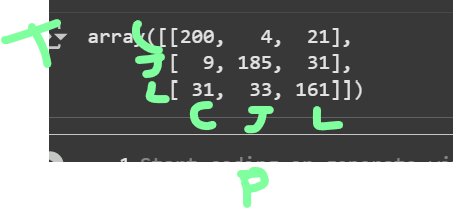


- it's clear the differences between jaguar and leopard are subtle, and distinguishing them requires certain lighting/angles to determine spot pattern
- the weak spot is leopard recall; cheetah tends to be the main fallback for the model when it is unsure on a leopard image (and therefore jaguar due to their similarities)

## custom image predictor

In [ ]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

@torch.no_grad()
def predict_image(
    image_path: str,
    model,
    class_names,
    transform,
    device="cuda" if torch.cuda.is_available() else "cpu",
    true_label=None,
    tta: bool = False,
    topk: int = 3,
    ):
  model.eval()

  # load image and convert to RGB
  img_pil = Image.open(image_path).convert("RGB")

  # convert to tensor and other transform properties
  x = transform(img_pil)
  x = x.unsqueeze(0).to(device)

  # forward - includes horizontal flip if desired
  with torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
    logits = model(x)
    if tta:
      x_flip = torch.flip(x, dims=[3])
      logits = (logits + model(x_flip)) / 2

  # prediction probabilities and labels
  probs = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()
  pred_idx = int(probs.argmax())
  pred_label = class_names[pred_idx]
  pred_prob = float(probs[pred_idx])

  # decide title colour
  color = "white"
  if true_label is not None:
    # allow int or str
    if isinstance(true_label, int):
      is_correct = (true_label == pred_idx)
    else:
      is_correct = (pred_label.lower() == str(true_label).lower())
    color = "lime" if is_correct else "red"

  # show image and prediction
  plt.figure(figsize=(5, 5))
  plt.imshow(img_pil)
  plt.axis("off")
  plt.title(f"{pred_label} • {pred_prob*100:.1f}%", color=color, fontsize=14)
  plt.show()

  # print topk table
  topk = min(topk, len(class_names))
  top_idx = np.argsort(-probs)[:topk] # sorts indices from largest to smallest taking topk
  print("Top-k predictions:")
  for i in top_idx:
    print(f"{class_names[i]:<10s} {probs[i]*100:5.1f}%")

  return {
      "pred_idx": pred_idx,
      "pred_label": pred_label,
      "pred_prob": pred_prob,
      "probs": probs
  }

testing with jaguar image...

In [ ]:
# jaguar image path
CUSTOM_PATH = Path("custom")
image_path_custom = CUSTOM_PATH / "jaguar_custom.jpg"
image_path_custom_2 = CUSTOM_PATH / "leopard_custom.jpg"
image_path_custom_3 = CUSTOM_PATH / "leopard_custom_2.jpg"
image_path_custom_4 = CUSTOM_PATH / "cheetah_custom.jpg"
image_path_custom_5 = CUSTOM_PATH / "cheetah_custom_2.jpeg"

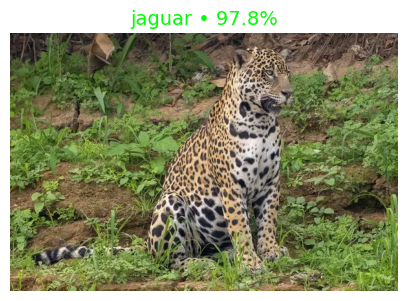

Top-k predictions:
jaguar      97.8%
leopard      2.1%
cheetah      0.1%


{'pred_idx': 1,
 'pred_label': 'jaguar',
 'pred_prob': 0.97802734375,
 'probs': array([7.353e-04, 9.780e-01, 2.119e-02], dtype=float16)}

In [ ]:
predict_image(image_path=image_path_custom,
              model=model,
              class_names=val_loader.dataset.classes,
              transform=val_tfms,
              device="cuda",
              true_label="jaguar",
              tta=False,
              topk=3)

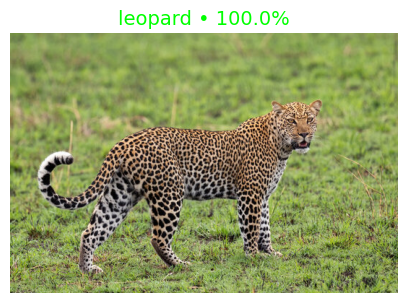

Top-k predictions:
leopard    100.0%
cheetah      0.0%
jaguar       0.0%


{'pred_idx': 2,
 'pred_label': 'leopard',
 'pred_prob': 1.0,
 'probs': array([0., 0., 1.], dtype=float16)}

In [ ]:
predict_image(image_path=image_path_custom_2,
              model=model,
              class_names=val_loader.dataset.classes,
              transform=val_tfms,
              device="cuda",
              true_label="leopard",
              tta=False,
              topk=3)

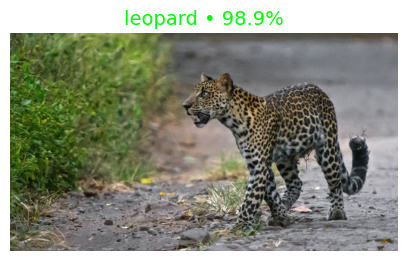

Top-k predictions:
leopard     98.9%
jaguar       1.1%
cheetah      0.0%


{'pred_idx': 2,
 'pred_label': 'leopard',
 'pred_prob': 0.98876953125,
 'probs': array([3.355e-04, 1.083e-02, 9.888e-01], dtype=float16)}

In [ ]:
predict_image(image_path=image_path_custom_3,
              model=model,
              class_names=val_loader.dataset.classes,
              transform=val_tfms,
              device="cuda",
              true_label="leopard",
              tta=False,
              topk=3)

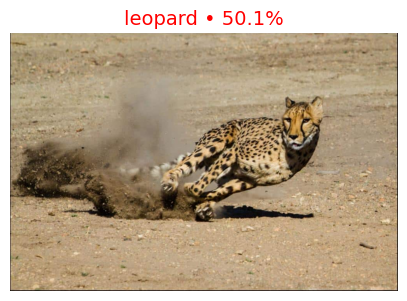

Top-k predictions:
leopard     50.1%
cheetah     47.8%
jaguar       2.1%


{'pred_idx': 2,
 'pred_label': 'leopard',
 'pred_prob': 0.5009765625,
 'probs': array([0.4783 , 0.02066, 0.501  ], dtype=float16)}

In [ ]:
predict_image(image_path=image_path_custom_4,
              model=model,
              class_names=val_loader.dataset.classes,
              transform=val_tfms,
              device="cuda",
              true_label="cheetah",
              tta=False,
              topk=3)

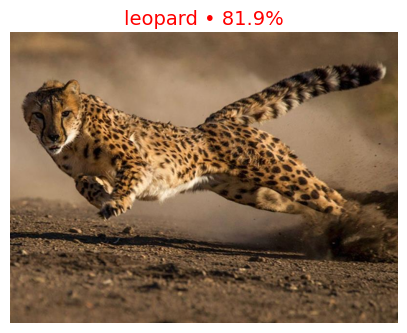

Top-k predictions:
leopard     81.9%
cheetah     17.0%
jaguar       1.1%


{'pred_idx': 2,
 'pred_label': 'leopard',
 'pred_prob': 0.8193359375,
 'probs': array([0.1697 , 0.01104, 0.8193 ], dtype=float16)}

In [ ]:
predict_image(image_path=image_path_custom_5,
              model=model,
              class_names=val_loader.dataset.classes,
              transform=val_tfms,
              device="cuda",
              true_label="cheetah",
              tta=False,
              topk=3)

conclusion thoughts:
- 0.81 macro-f1 on test is very good considering that i dont think the average human could differentiate between cheetah, jaguar, and leopard.
- leopard was consistently lower in precision and recall. i do think part of the low precision was due to train data quality; i did see that some of the leopard images were just pawprints. lower recall i do think is due to the very discreet differences between leopard and jaguar, which made the model very reliant on these features. and if they weren't accessible, the model would just default to cheetah (hence 0.89 recall compared to 0.82 and 0.72).
- it also seems that on custom images, if the input image involves dynamic movement, the model just predicts leopard overwhelmingly. this could indicate that our training data lacks images of dynamic cheetahs and jaguars.
- initially a lot of augmentation was included, but results were coming back poor. as we simplified the data manipulation, our scores improved. this is likely due to the subtle differences that distinguish between the three cats.
- this model probably could be improved further with greater train data and variety, and maybe even a whole new model architecture.